# Learning geometry of geodesics

This is the work done with Samuel Gruffaz on using RKHS to learn the shape of the geodesics.

In [1]:
import numpy as np
import pandas as pd
import torch
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import sys, os


os.chdir("/Users/samuel.gruffaz/Documents/PEcollab")

from leaspy.api import Leaspy

from leaspy import Leaspy, Data, AlgorithmSettings, Plotter, Dataset, IndividualParameters
from leaspy.models.utils.attributes.attributes_factory import AttributesFactory
from leaspy.algo.algo_factory import AlgoFactory
from leaspy.utils.visualisation.visual_update_b import *




In [2]:
def generate_data(model, n_individuals, nb_visits_min, nb_visits_mean, window):
    # Sampling individuals :

    N = n_individuals

    individuals = []

    data = [[], []] + [[] for k in range(model.dimension)]

    for i in range(N):
        tau = np.random.normal(loc=model.parameters['tau_mean'], scale=model.parameters['tau_std'])
        xi = np.random.normal(loc=model.parameters['xi_mean'], scale=model.parameters['xi_std'])
        n_tpts = nb_visits_min + np.random.binomial(2 * (nb_visits_mean-nb_visits_min),0.5)
        tpts = np.sort((np.random.normal(0., 1., size=(n_tpts)) * window) + tau)
        timepoints = torch.tensor(tpts, dtype=float)
        sources = None
        if model.source_dimension is not None:
            sources = np.random.normal(loc=model.parameters['sources_mean'], scale=model.parameters['sources_std'], size=(model.source_dimension))
            values = model.compute_individual_tensorized(timepoints, {"tau":torch.tensor(tau), "xi":torch.tensor(xi), "sources":torch.Tensor(sources)}).detach().numpy()
        else:   
            values = model.compute_individual_tensorized(timepoints, {"tau":torch.tensor(tau), "xi":torch.tensor(xi)}).detach().numpy()
        values = values + np.random.normal(0., model.parameters['noise_std'], size=(n_tpts, model.dimension))
        individuals.append({"idx":i+1, "tau":tau, "xi":xi, "tpts":tpts, "sources":sources, "values":values})
        data[0] += [i+1] * n_tpts
        data[1] += list(tpts)
        for k in range(model.dimension):
            data[2+k] += list(values[0, :, k])
    data = np.array(data).T
    df = pd.DataFrame(data, columns=['ID', 'TIME']+["Y"+str(k+1) for k in range(model.dimension)])
    df.set_index(['ID', 'TIME'], inplace=True)
    return df, individuals

def plot_generative(ax, individuals, model1, nb_ind_plot, dimension):

    for i in range(nb_ind_plot):
        params = individuals[i]
        mean_par = {key:torch.tensor(params[key])for key in ["tau", "xi"]}
        mean_par["sources"] = torch.Tensor(params["sources"])
        t = torch.tensor(np.linspace(np.min(params["tpts"])-1.,np.max(params["tpts"])+1.,100), dtype=torch.float)

        trajectory = model1.compute_individual_tensorized(t, mean_par).squeeze(0)
        for j in range(dimension):
            ax[i,j].plot(individuals[i]['tpts'], individuals[i]['values'][0,:,j], "o")
            ax[i,j].plot(t, trajectory[..., j])

def plot_points(ax, dataset, nb_ind_plot, dimension):
    tps=dataset.timepoints
    Y=dataset.values
    mask=dataset.mask
    for i in range(nb_ind_plot):
        ind=mask[i].bool().all(axis=1)
        
        Z=Y[i,ind]
        tpsi=tps[i,ind]
       
      
        for j in range(dimension):
            ax[i,j].plot(tpsi, Z[:,j], "o")
            

def plot_fit(ax, results, model, dataset,nb_ind_plot, dimension):
    tps=dataset.timepoints
    
    for i in range(nb_ind_plot):
        tpts=tps[i,:dataset.nb_observations_per_individuals[i]].numpy()
        
        params = results._individual_parameters[results._indices[i]]
        params["tpts"]=tpts
        mean_par = {key:torch.tensor(params[key])for key in ["tau", "xi"]}
        mean_par["sources"] = torch.Tensor(params["sources"])
        t = torch.tensor(np.linspace(np.min(params["tpts"])-1.,np.max(params["tpts"])+1.,100), dtype=torch.float)

        trajectory = model.compute_individual_tensorized(t, mean_par).squeeze(0)
        for j in range(dimension):
            ax[i,j].plot(t, trajectory[..., j])

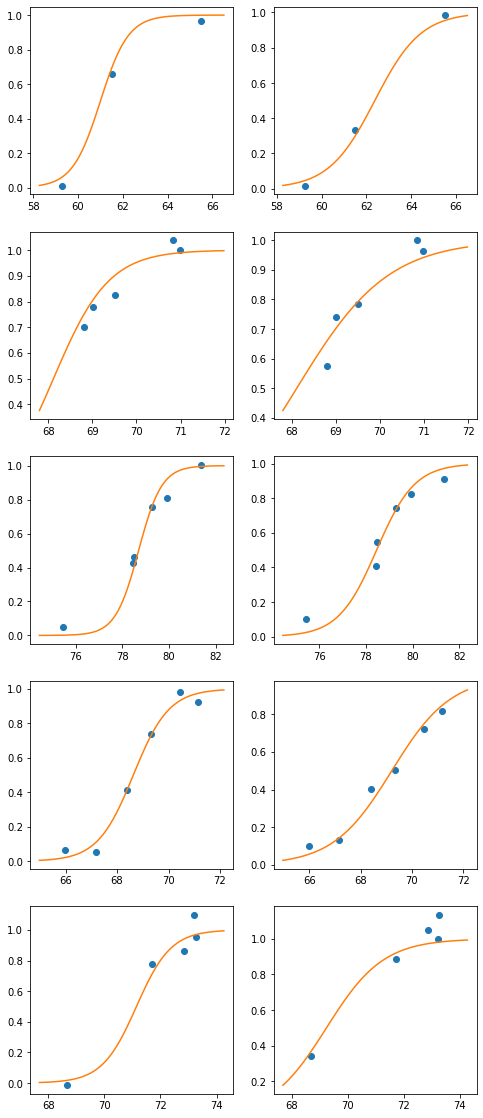

In [3]:
leaspy = Leaspy('linearB')
dimension = 2
sources_dimension = 1
leaspy.model.parameters = {'g': [0., 1.],
                           'v0':[.5, 0.],
                           'betas':[[1.]],
                           'tau_mean': 70., 'tau_std': 5.,
                           'xi_mean': 0., 'xi_std': .1,
                           'sources_mean': 0.,
                           'sources_std': 1.,
                           'noise_std': [.07]}
model1 = leaspy.model
model1.dimension = dimension
model1.source_dimension = sources_dimension
model1.parameters = {key: torch.tensor(val) for key, val in model1.parameters.items()}
model1.attributes = AttributesFactory.attributes(model1.name, dimension, sources_dimension)
model1.attributes._compute_positions(model1.parameters)
model1.attributes._compute_velocities(model1.parameters)
model1.attributes._compute_betas(model1.parameters)
model1.attributes._compute_orthonormal_basis()
model1.attributes._compute_mixing_matrix()
model1.is_initialized = True

periode = 15.
amplitude = 2.
model1.B = lambda x : 1./(1.+torch.exp(-x))

n_individuals = 100
nb_visits_min = 2
nb_visits_mean = 4
window = 2.

data, individuals = generate_data(model1, n_individuals, nb_visits_min, nb_visits_mean, window)

leaspy_data = Data.from_dataframe(data)

nb_ind_plot = 5

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(dimension * 4, nb_ind_plot * 4))

plot_generative(ax, individuals, model1, nb_ind_plot, dimension)
plt.show()

In [4]:


os.chdir("/Users/samuel.gruffaz/Documents/data")
leaspy_data=Data.from_csv_file("Join5score.csv")
dataset = Dataset(leaspy_data)
os.chdir("/Users/samuel.gruffaz/Documents/PEcollab")

over-fitting avec un grand nombre de points dec ontrole

ization is:
HVLT_TOTAL: 0.0802
SCOPA_TOTAL: 0.0426
MOCA_TOTAL: 0.0575
BENTON_JLO: 0.0847
SCHWAB_AND_ENGLAND: 0.0835

Personalization scipy_minimize took: 2min 59s
erreur projection
0.009804423
temps opti quadra
0.01176100000157021
|--------------------------------------------------|   0/300 iterations
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 1
=Samplers 
    g rate : 4.00%, std: 0.00500
    v0 rate : 1.60%, std: 0.00500
    tau rate : 3.99%, std: 0.10000
    xi rate : 3.47%, std: 0.10000
    sources rate : 3.65%, std: 0.10000
    betas rate : 4.00%, std: 0.00500

=== MODEL ===
g : tensor([-1.0959, -1.6107, -2.1797, -1.7406, -2.3236])
v0 : tensor([-3.0753, -3.0303, -2.7546, -2.9832, -3.1439])
betas : tensor([[ 0.4922, -0.1484],
        [-0.1508,  0.0753],
        [-0.2064, -0.4150],
        [ 0.2855, -0.0422]])
tau_mean : 64.20464324951172
tau_std : 8.854801177978516
xi_mean : 0.0
xi_std : 0.10645455121994019
sources_mean : 0.0
sources_std : 1.0
noise_std : tensor([0.

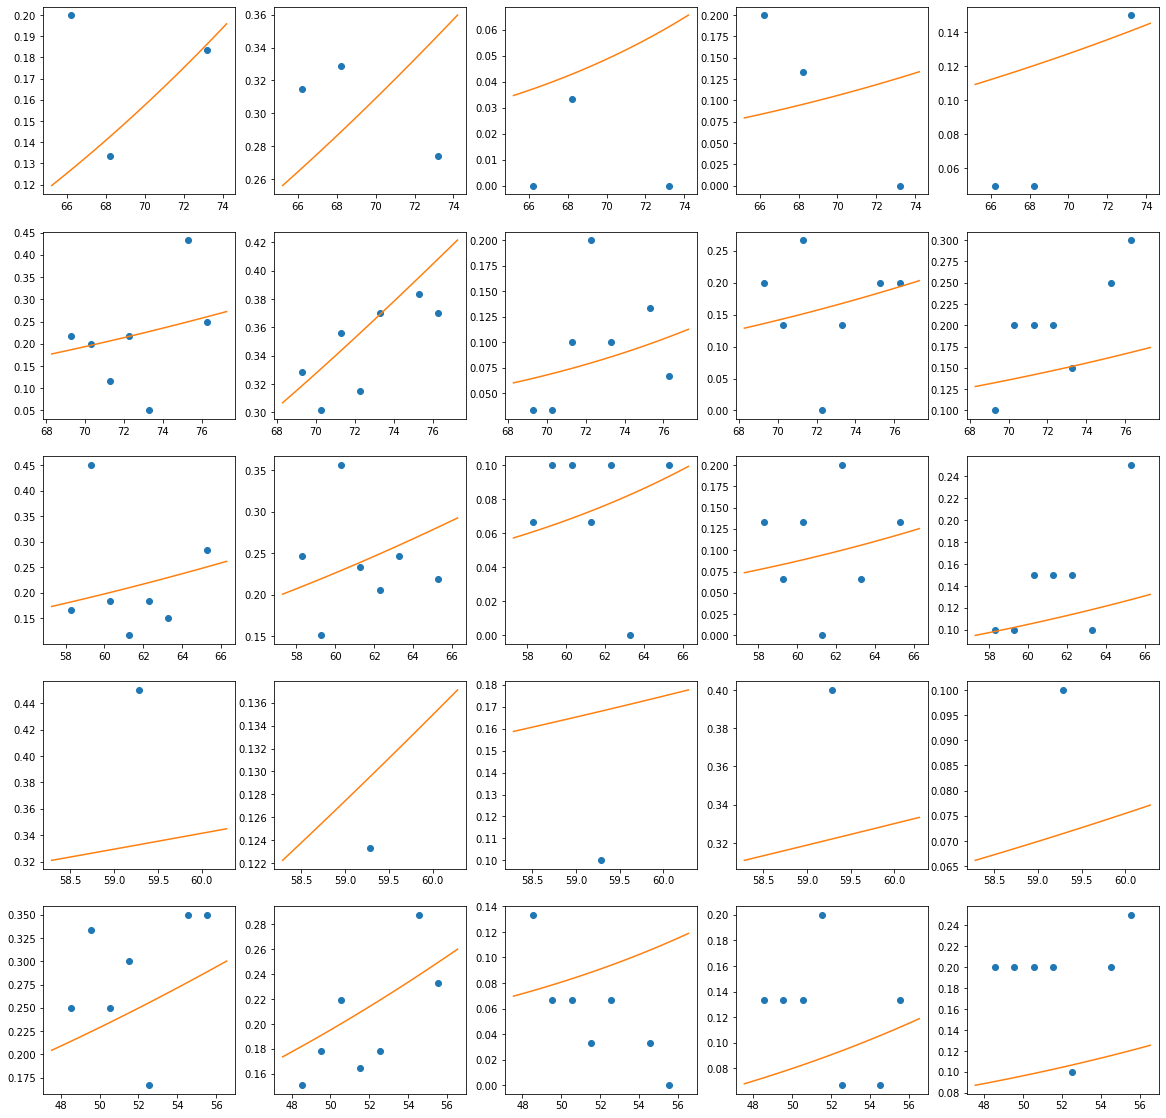

In [29]:
leaspy_test = Leaspy('linearB')
nb_ind_plot=5
dimension=5
leaspy_test.model.load_hyperparameters({'source_dimension': 2}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1.,
                 "nb_control_points" : 10,"nb_compose":4,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'init_b':'logistic'}

algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1500, loss="MSE_diag_noise",progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")
algo_settings.set_logs(
    path='example/start/outputs/logs', # Creates a logs file ; if existing, ask if rewrite it
    plot_periodicity=50, # Saves the values to display in pdf every 50 iterations
    save_periodicity=10, # Saves the values in csv files every 10 iterations
    console_print_periodicity=50, # if = N, it display logs in the console/terminal every N iterations
    overwrite_logs_folder=True # if True and the logs folder already exists, it entirely overwrites it
)
fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))



results=leaspy_test.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
leaspy_test.save('example/start/outputs/logs/mod10consig1.json')   
plt.show()

In [6]:
leaspy_test=leaspy.load('example/start/outputs/logs/mod10consig1.json')

/Users/samuel.gruffaz/Documents/PEcollab/leaspy/models/linear_B.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W1=torch.tensor(W, dtype=torch.float32).clone().detach()
/Users/samuel.gruffaz/Documents/PEcollab/leaspy/models/linear_B.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_filtre1=torch.tensor(X_filtre, dtype=torch.float32).clone().detach()


0
    xi rate : 3.31%, std: 0.10000
    sources rate : 3.56%, std: 0.10000
    betas rate : 4.00%, std: 0.00500

=== MODEL ===
g : tensor([-1.1645, -1.6936, -2.2950, -1.8335, -2.4485])
v0 : tensor([-3.0040, -2.9654, -2.6960, -2.9912, -2.9505])
betas : tensor([[ 0.5595, -0.0993],
        [-0.1907,  0.0060],
        [-0.0935,  0.5202],
        [ 0.3070, -0.0797]])
tau_mean : 62.60150146484375
tau_std : 8.738070487976074
xi_mean : 0.0
xi_std : 0.09567241370677948
sources_mean : 0.0
sources_std : 1.0
noise_std : tensor([0.0797, 0.0432, 0.0576, 0.0836, 0.0832])

Duration since last print : 2.8428s
|########------------------------------------------|   48/300 iterations
=== ALGO ===
Instance of MCMC_SAEM (tensor) algo 
Iteration 50
=Samplers 
    g rate : 82.40%, std: 0.00605
    v0 rate : 88.80%, std: 0.00605
    tau rate : 98.89%, std: 0.12100
    xi rate : 60.94%, std: 0.12039
    sources rate : 83.45%, std: 0.12100
    betas rate : 73.00%, std: 0.00598

=== MODEL ===
g : tensor([-1.1652,

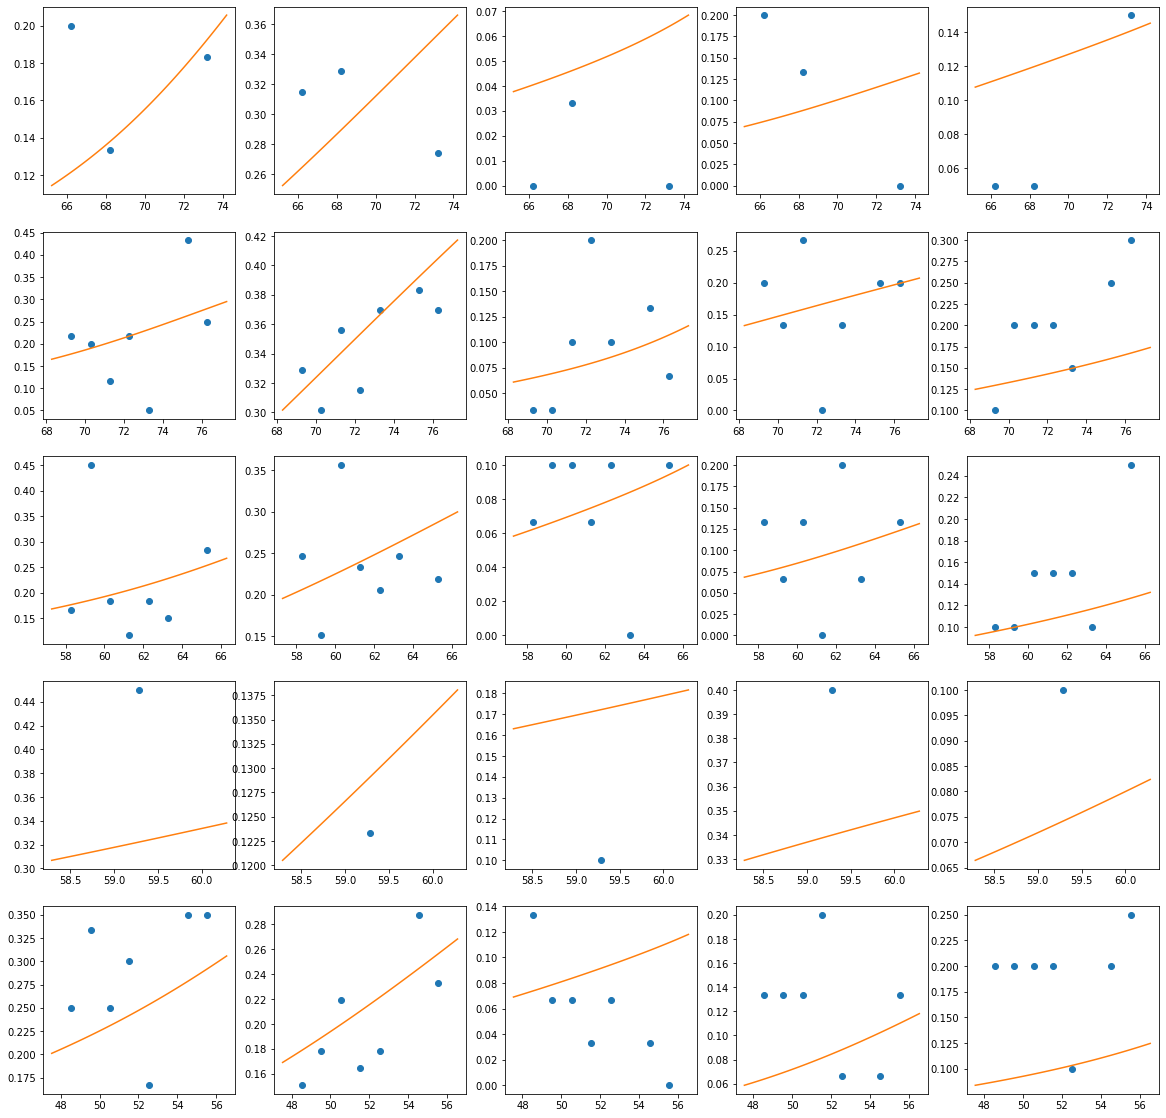

In [28]:
leaspy_test = Leaspy('linearB')
nb_ind_plot=5
dimension=5
leaspy_test.model.load_hyperparameters({'source_dimension': 2}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 0.2,
                 "nb_control_points" : 10,"nb_compose":4,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'init_b':'logistic'}

algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1500, loss="MSE_diag_noise",progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")
algo_settings.set_logs(
    path='example/start/outputs/logs', # Creates a logs file ; if existing, ask if rewrite it
    plot_periodicity=50, # Saves the values to display in pdf every 50 iterations
    save_periodicity=10, # Saves the values in csv files every 10 iterations
    console_print_periodicity=50, # if = N, it display logs in the console/terminal every N iterations
    overwrite_logs_folder=True # if True and the logs folder already exists, it entirely overwrites it
)
fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))



results=leaspy_test.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
leaspy_test.save('example/start/outputs/logs/mod10con.json')   
plt.show()

sigma med
tensor(0.3238)
|##################################################|   200/200 iterations
The standard deviation of the noise at the end of the calibration is:
HVLT_TOTAL: 0.0898
SCOPA_TOTAL: 0.0488
MOCA_TOTAL: 0.0596
BENTON_JLO: 0.1290
SCHWAB_AND_ENGLAND: 0.0500

Calibration took: 5min 53s

The standard deviation of the noise at the end of the personalization is:
HVLT_TOTAL: 0.0851
SCOPA_TOTAL: 0.0422
MOCA_TOTAL: 0.0574
BENTON_JLO: 0.1278
SCHWAB_AND_ENGLAND: 0.0452

Personalization scipy_minimize took: 3min 1s
erreur projection
0.0032388382
temps opti quadra
0.013194999999541324
|##################################################|   200/200 iterations
The standard deviation of the noise at the end of the calibration is:
HVLT_TOTAL: 0.0903
SCOPA_TOTAL: 0.0478
MOCA_TOTAL: 0.0601
BENTON_JLO: 0.1276
SCHWAB_AND_ENGLAND: 0.0510

Calibration took: 7min 36s

The standard deviation of the noise at the end of the personalization is:
HVLT_TOTAL: 0.0858
SCOPA_TOTAL: 0.0421
MOCA_TOTAL: 0.

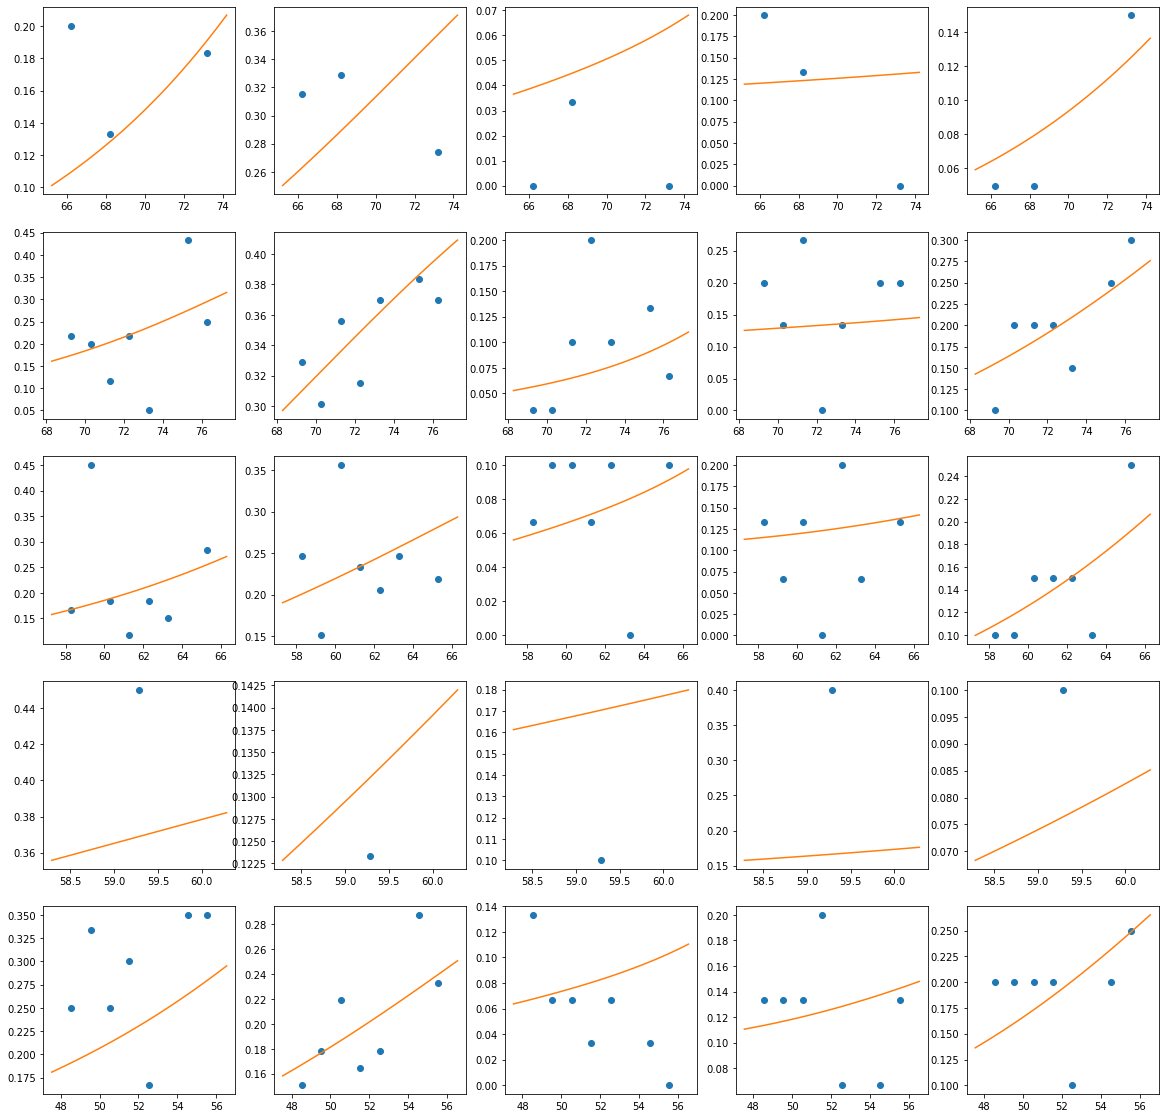

In [22]:
meta_settings = {"kernel_name" : "gaussian", 
                 "sigma_auto" : True, 
                 "nb_control_points" : 5,"nb_compose":3,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'iter_begin_fit':200,'init_real':results}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE',progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))



results=leaspy_test.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
leaspy_test.save('example/start/outputs/logs/mod11.json')   
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
    

|##################################################|   3000/3000 iterations
The standard deviation of the noise at the end of the calibration is:
HVLT_TOTAL: 0.0930
SCOPA_TOTAL: 0.0492
MOCA_TOTAL: 0.0588
BENTON_JLO: 0.1284
SCHWAB_AND_ENGLAND: 0.0510

Calibration took: 2min 10s


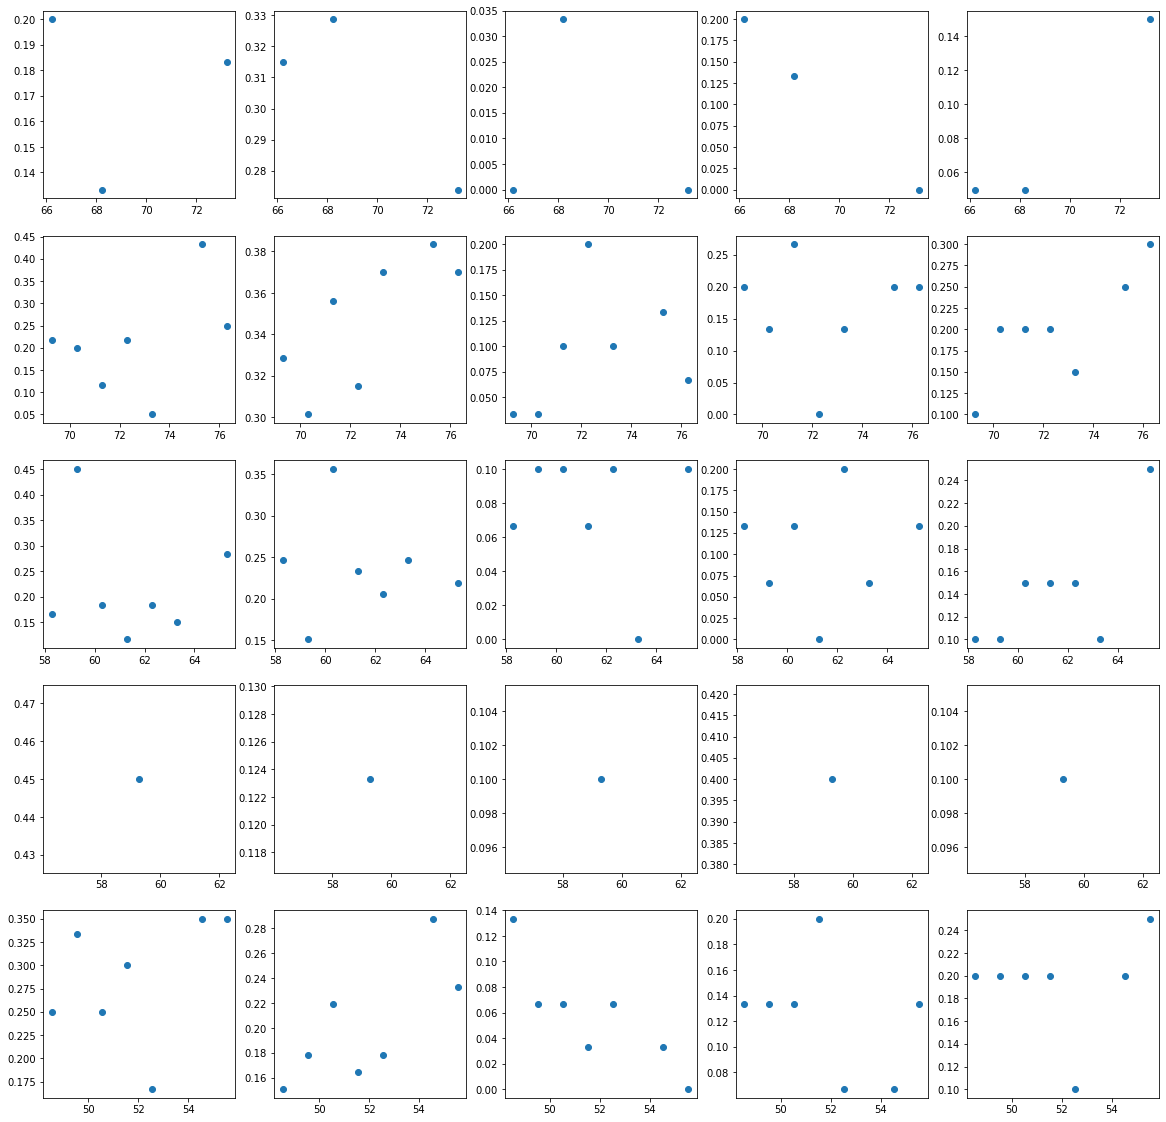

In [26]:
logistic = Leaspy('logistic')
nb_ind_plot=5
dimension=5
leaspy_test.model.load_hyperparameters({'source_dimension': 4}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma_auto" : True,
                 "nb_control_points" : 5,"nb_compose":4,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'init_b':'logistic'}

algo_settings = AlgorithmSettings('mcmc_saem', n_iter=3000, loss="MSE_diag_noise",progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")
#algo_settings.set_logs(
    #path='example/start/outputs/logs', # Creates a logs file ; if existing, ask if rewrite it
    #plot_periodicity=50, # Saves the values to display in pdf every 50 iterations
    #save_periodicity=10, # Saves the values in csv files every 10 iterations
    #console_print_periodicity=50, # if = N, it display logs in the console/terminal every N iterations
    #overwrite_logs_folder=True # if True and the logs folder already exists, it entirely overwrites it
#)
fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))

logistic.fit(leaspy_data,algo_settings)

#results=leaspy_test.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
#plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
#leaspy_test.save('example/start/outputs/logs/mod1.json')   
plt.show()

In [4]:
leaspy_test = Leaspy('linearB')
nb_ind_plot=5
dimension=2
leaspy_test.model.load_hyperparameters({'source_dimension': 2}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma_auto" : False, "sigma":0.5,
                 "nb_control_points" : 2,"nb_compose":2,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'init_b':'logistic'}

algo_settings = AlgorithmSettings('mcmc_saem', n_iter=100, loss="MSE_diag_noise",progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")
algo_settings.set_logs(
    path='example/start/outputs/logs', # Creates a logs file ; if existing, ask if rewrite it
    plot_periodicity=50, # Saves the values to display in pdf every 50 iterations
    save_periodicity=10, # Saves the values in csv files every 10 iterations
    console_print_periodicity=50, # if = N, it display logs in the console/terminal every N iterations
    overwrite_logs_folder=True # if True and the logs folder already exists, it entirely overwrites it
)
fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))



results=leaspy_test.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
leaspy_test.save('example/start/outputs/logs/mod.json')   
plt.show()


...overwrite logs folder...


KeyboardInterrupt: 

In [ ]:
leaspy_test.save('example/start/outputs/logs/mod.json')  

In [6]:
leaspy_test=Leaspy.load('example/start/outputs/logs/mod.json')

FileNotFoundError: [Errno 2] No such file or directory: 'example/start/outputs/logs/mod.json'

In [12]:
dimension=4

In [10]:
print(len(leaspy_test.model.saveB))

5


In [8]:

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))




plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
    
plt.show()

NameError: name 'results' is not defined

In [9]:
a=torch.tensor([0])

print(type(a))

<class 'torch.Tensor'>


4
/Users/samuel.gruffaz/Documents/PEcollab/leaspy/models/linear_B.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W1=torch.tensor(W, dtype=torch.float32).clone().detach()
/Users/samuel.gruffaz/Documents/PEcollab/leaspy/models/linear_B.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_filtre1=torch.tensor(X_filtre, dtype=torch.float32).clone().detach()
/Users/samuel.gruffaz/Documents/PEcollab/leaspy/models/linear_B.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W1=torch.tensor(W, dtype=torch.float32).clone().detach()
/Users

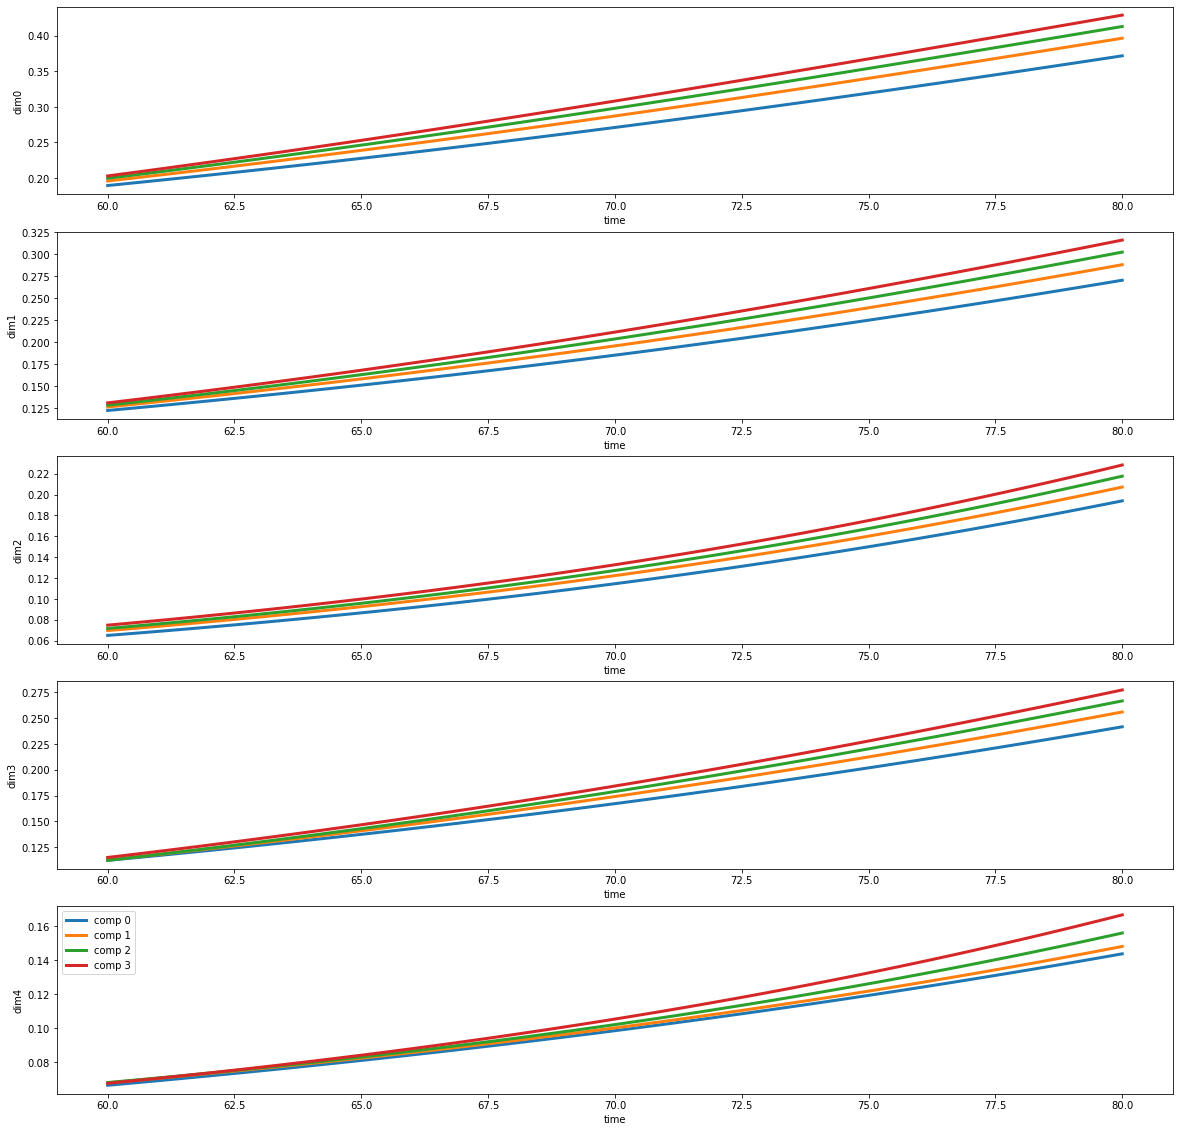

In [7]:
dimension=5
nb_ind_plot=5
fig, ax = plt.subplots( dimension, figsize=(4*dimension,4*nb_ind_plot))

plot_average_update(leaspy_test,ax)
plt.legend()
fig.show()

In [10]:
a=1
list(a)

TypeError: 'int' object is not iterable

2


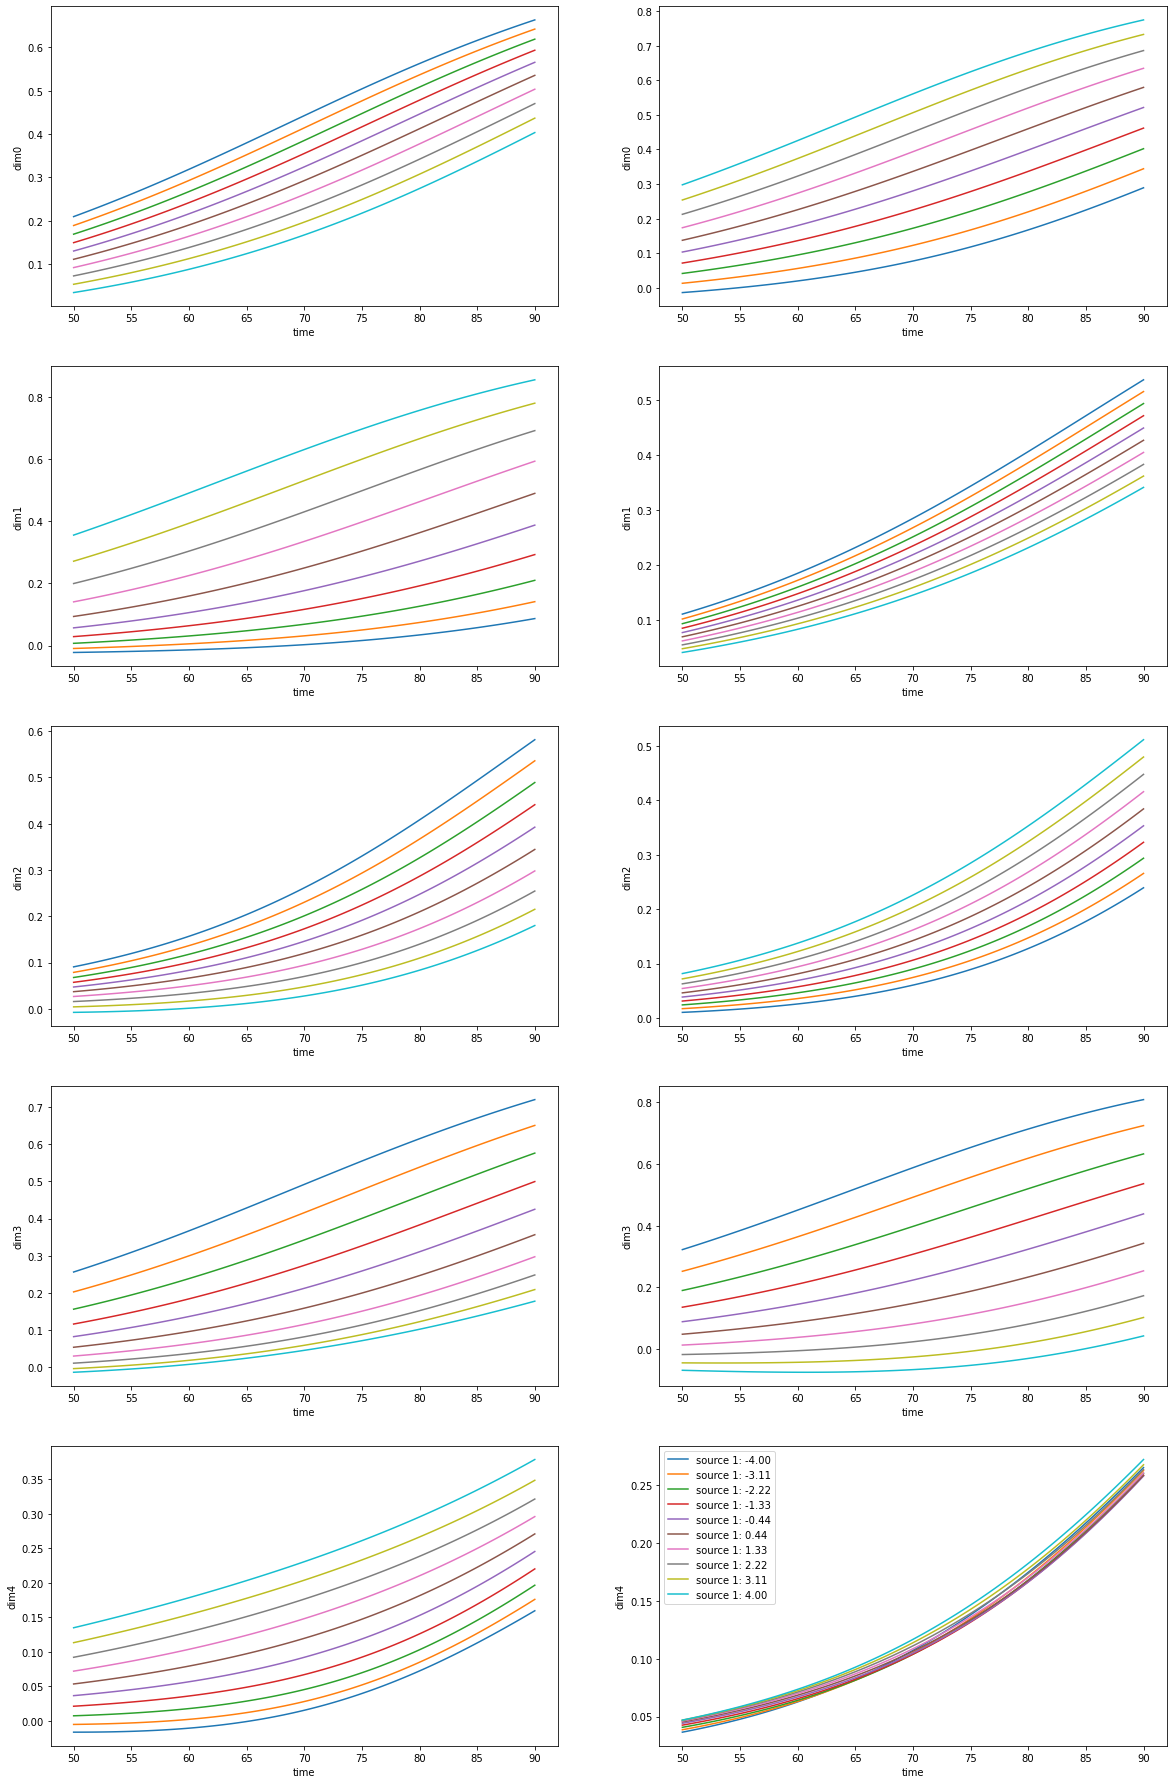

In [8]:
tps=torch.linspace(50,90,100)
nb_vari=10
fen=4
plot_variability(leaspy_test,tps,nb_vari,fen)

In [11]:
def plot_average_update(model,ax,modelref=None):
    """
    Parameters: model, linear_b model already calibrated with update_b
        ax, (dimension) subplots

    """
    timepoints = np.linspace(60, 80, 100)
    if modelref is not None:
        number_of_sources = modelref.model.random_variable_informations()["sources"]["shape"][0]
        mean_xiref = modelref.model.parameters['xi_mean'].numpy()
        mean_tauref = modelref.model.parameters['tau_mean'].numpy()
        mean_sourceref = modelref.model.parameters['sources_mean'].numpy().tolist()
        mean_sourcesref = [mean_source]*number_of_sources
        average_parametersref = {'xi': mean_xiref,'tau': mean_tauref,'sources': mean_sourcesref}
        ip_averageref = IndividualParameters()
        ip_averageref.add_individual_parameters('average', average_parametersref)
        valuesref = model.estimate({'average': timepoints}, ip_averageref)
        for i in range(d):
            ax[i].plot(timepoints, valuesref['average'].T[i], linewidth=3,label=modelref.name)


    # —— Get the average individual parameters
    d=model.model.dimension
    
    Lparam=model.model.saveParam
    LB=model.model.saveB.copy()
    print(len(LB))
    for i in range(d):
        
        number_of_sources = model.model.random_variable_informations()["sources"]["shape"][0]
        for j in range(len(LB)):
            
            mean_xi = Lparam[j]['xi_mean'].numpy()
            mean_tau = Lparam[j]['tau_mean'].numpy()
            mean_source = Lparam[j]['sources_mean'].numpy().tolist()
            mean_sources = [mean_source]*number_of_sources
            model.model.saveB=LB[:j]
            model.model.reconstructionB()

# —— Store the average individual parameters in a dedicated object
            average_parameters = {'xi': mean_xi,'tau': mean_tau,'sources': mean_sources}
            ip_average = IndividualParameters()
            ip_average.add_individual_parameters('average', average_parameters)
            values = model.estimate({'average': timepoints}, ip_average)
            
            ax[i].plot(timepoints, values['average'].T[i], linewidth=3,label="comp "+str(j))
        ax[i].set_xlabel("time")
        ax[i].set_ylabel("dim"+str(i))
        
    model.model.saveB=LB

In [55]:
def plot_variability(model, tps,nb_vari,fen):
    params={}
    

    nb_s=model.model.source_dimension
    print(nb_s)
    dimension=model.model.dimension
    fig1, ax1 = plt.subplots(dimension, nb_s, figsize=(4*dimension,16*nb_s))
    for i in range(nb_s):
        SS=torch.zeros(nb_vari,nb_s)
        SS[:,i]=torch.linspace(-fen,fen,nb_vari)
        
        t = tps

        
        for j in range(dimension):
            for k in range(nb_vari):
        
                mean_par={"tau":model.model.parameters["tau_mean"],"xi":model.model.parameters["xi_mean"]}
                mean_par["sources"] = SS[k]
                trajectory = model.model.compute_individual_tensorized(t, mean_par).squeeze(0)
                
                if len(ax1.shape)>1:
                    ax1[j,i].plot(t, trajectory[..., j],label="source "+str(i)+": {:.2f}".format(SS[k,i]))
                else:
                    ax1[j].plot(t, trajectory[..., j],label="source "+str(i)+": {:.2f}".format(SS[k,i]))
    plt.legend()
    plt.show()

10
/opt/anaconda3/envs/leaspy/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


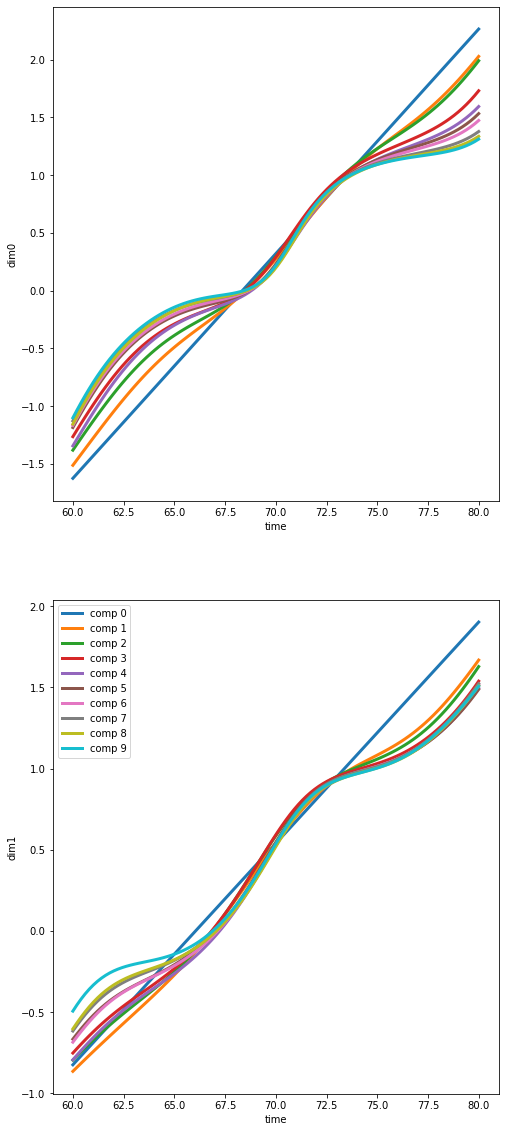

In [27]:

fig, ax = plt.subplots( dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_average_update(leaspy_test,ax)
plt.legend()
fig.show()

|##################################################|   100/100 iterations
The standard deviation of the noise at the end of the calibration is:
0.0953

Calibration took: 7s

The standard deviation of the noise at the end of the personalization is:
0.0789

Personalization scipy_minimize took: 19s
erreur projection
0.00016685652
temps opti quadra
0.0028089999999849624
|##################################################|   200/200 iterations
The standard deviation of the noise at the end of the calibration is:
0.0913

Calibration took: 17s

The standard deviation of the noise at the end of the personalization is:
0.0755

Personalization scipy_minimize took: 23s
erreur projection
0.00087064225
temps opti quadra
0.002726000000023987
|##################################################|   200/200 iterations
The standard deviation of the noise at the end of the calibration is:
0.0875

Calibration took: 20s

The standard deviation of the noise at the end of the personalization is:
0.0732

Perso

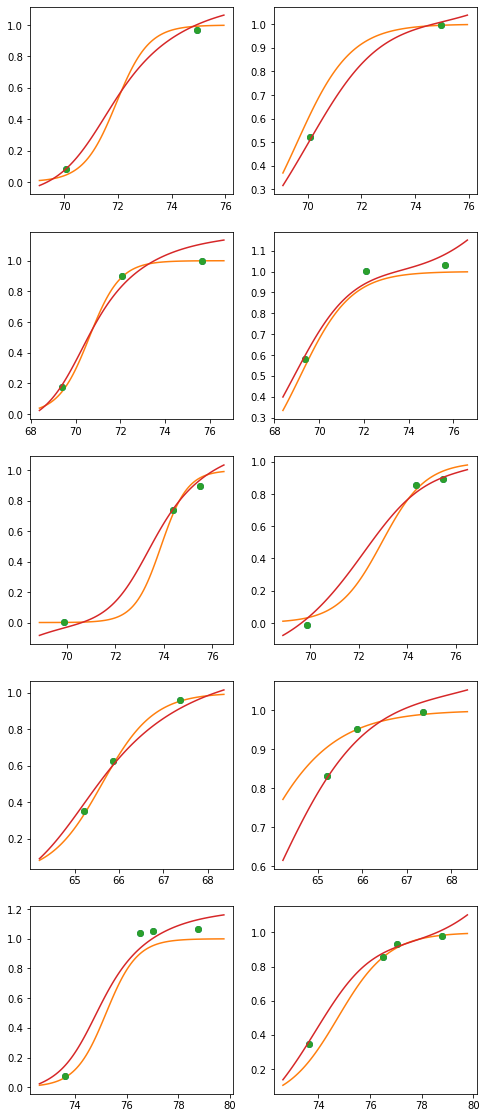

In [9]:
meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1., 
                 "nb_control_points" : 5,"nb_compose":5,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'iter_begin_fit':100,'init_real':results}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE',progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
    
plt.show()

10
/opt/anaconda3/envs/leaspy/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


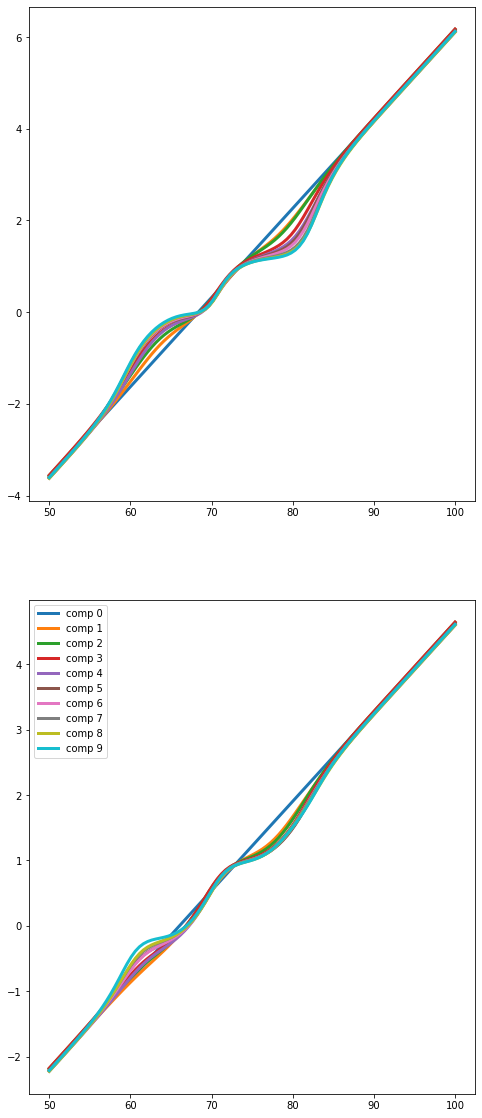

In [10]:
fig, ax = plt.subplots( dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_average_update(leaspy_test,ax)
plt.legend()
fig.show()

|##################################################|   1000/1000 iterations
The standard deviation of the noise at the end of the calibration is:
0.1247

Calibration took: 5s

The standard deviation of the noise at the end of the personalization is:
0.1040

Personalization scipy_minimize took: 8s
erreur projection
0.00027145393
1
2
4
temps opti quadra
0.0010519999998450658
|##################################################|   200/200 iterations
The standard deviation of the noise at the end of the calibration is:
0.1015

Calibration took: 4s

The standard deviation of the noise at the end of the personalization is:
0.0844

Personalization scipy_minimize took: 11s
erreur projection
0.00017931251
1
2
temps opti quadra
0.0007959999998092826
|##################################################|   200/200 iterations
The standard deviation of the noise at the end of the calibration is:
0.0872

Calibration took: 7s

The standard deviation of the noise at the end of the personalization is:
0.0

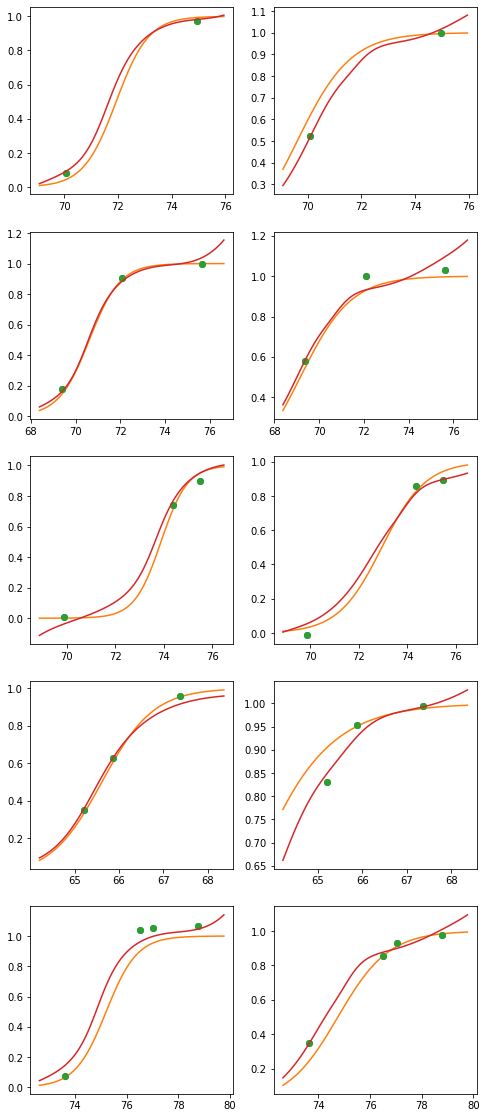

In [59]:
leaspy_test1 = Leaspy('linearB')
nb_ind_plot=5
dimension=2
leaspy_test1.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 0.4, 
                 "nb_control_points" : 5,"nb_compose":5,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'init_b':'identity'}

algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE',progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test1.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test1.model, dataset, nb_ind_plot, dimension)
    
plt.show()

5
/opt/anaconda3/envs/leaspy/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


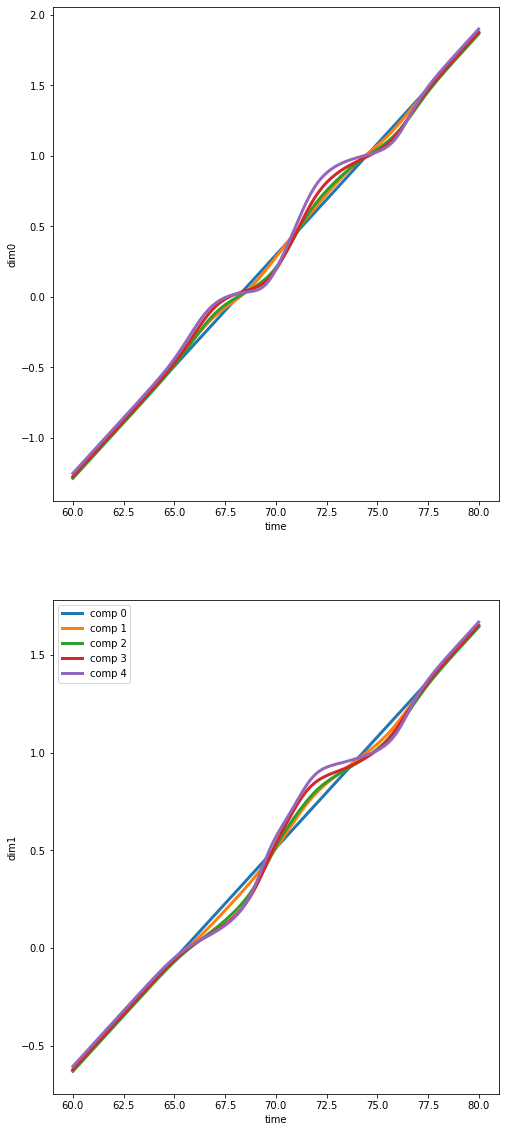

In [33]:
fig, ax = plt.subplots( dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_average_update(leaspy_test1,ax)
plt.legend()
fig.show()

si sigma est trop grand on arrive pas à s'adapter sans faire de la merde

choix de sigma automatisé en prenant la médiane des distances interpoints ?

|##################################################|   100/100 iterations
The standard deviation of the noise at the end of the calibration is:
0.0826

Calibration took: 7s

The standard deviation of the noise at the end of the personalization is:
0.0695

Personalization scipy_minimize took: 18s
erreur projection
0.00029722528
temps opti quadra
0.003185999999914202
|##################################################|   200/200 iterations
The standard deviation of the noise at the end of the calibration is:
0.0806

Calibration took: 17s

The standard deviation of the noise at the end of the personalization is:
0.0694

Personalization scipy_minimize took: 21s
erreur projection
0.00034285063
temps opti quadra
0.0025870000001759763
|##################################################|   200/200 iterations
The standard deviation of the noise at the end of the calibration is:
0.0805

Calibration took: 21s

The standard deviation of the noise at the end of the personalization is:
0.0696

Perso

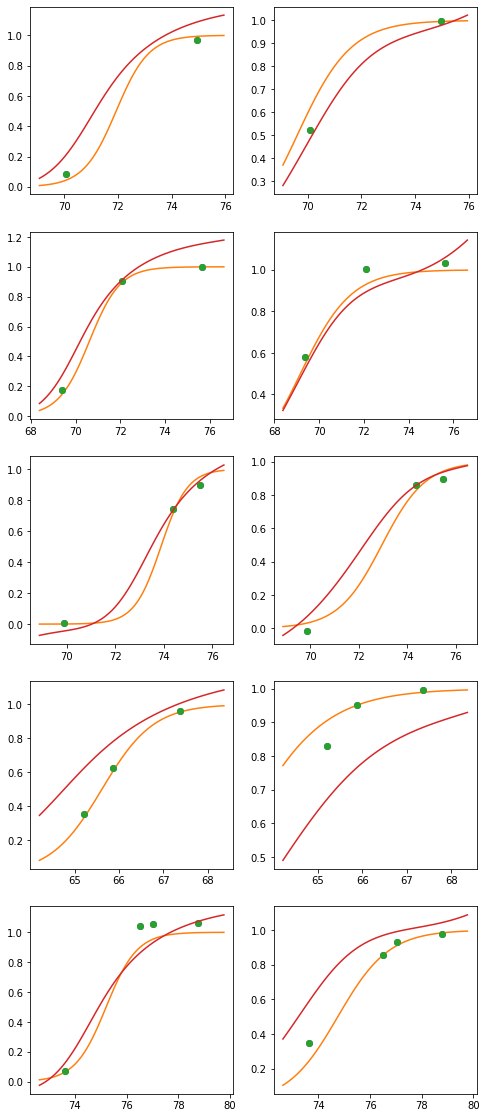

In [34]:
meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1., 
                 "nb_control_points" : 5,"nb_compose":5,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'iter_begin_fit':100,'init_real':results}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE',progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test1.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
    
plt.show()

1


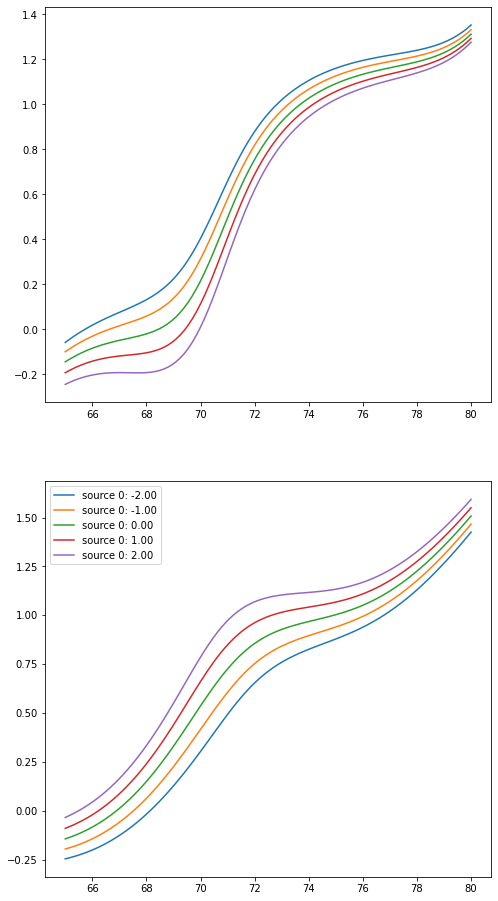

In [58]:
tps=torch.linspace(65,80,100)
nb_vari=5
fen=2
plot_variability(leaspy_test,tps,nb_vari,fen)

10
/opt/anaconda3/envs/leaspy/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


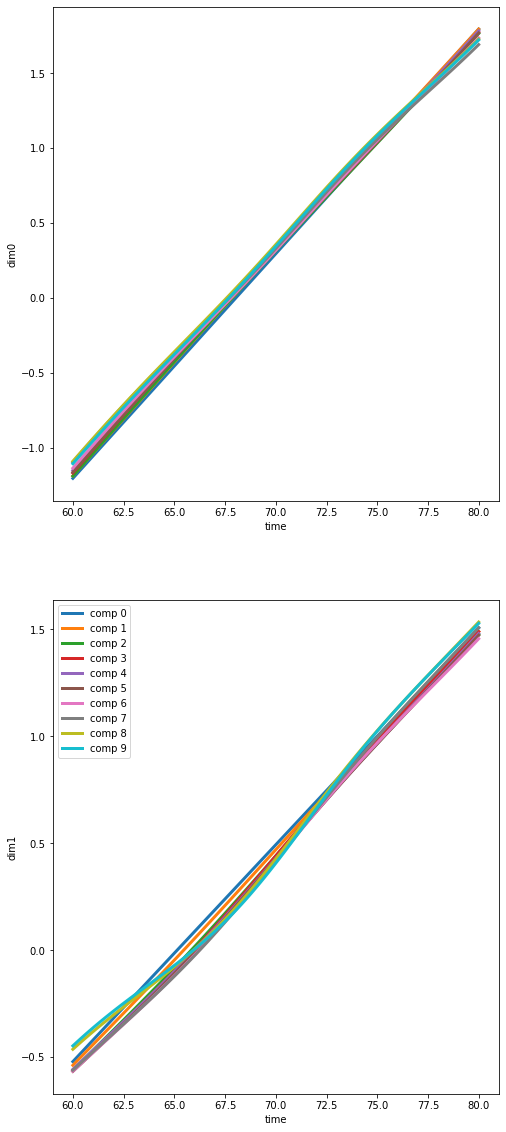

In [36]:
fig, ax = plt.subplots( dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_average_update(leaspy_test1,ax)
plt.legend()
fig.show()

In [72]:
data = Data.from_csv_file(os.path.join('example','start','inputs', 'data_normalized.csv'))
dataset = Dataset(data)

In [33]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dimension=4

logi=lambda: x: 1./(1.+torch.exp(-x))
meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1., 
                 "nb_control_points" : 10,"nb_compose":2,'init_b':"logistic"}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss="MSE_diag_noise")
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
#plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test.fit_B(data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()


The standard deviation of the noise at the end of the calibration is:
0.1056

Calibration took: 12s

The standard deviation of the noise at the end of the personalization is:
0.0986

Personalization scipy_minimize took: 25s
erreur projection
0.003049659
1
2
4
temps opti quadra
0.011233000000004267

The standard deviation of the noise at the end of the calibration is:
0.1013

Calibration took: 4min 3s

The standard deviation of the noise at the end of the personalization is:
0.0948

Personalization scipy_minimize took: 42s
erreur projection
0.003307317
1
2
temps opti quadra
0.004680000000007567
tensor([81.6610, 82.1360, 82.6820, 83.1390, 83.6910, 84.6550, 85.6910, 86.6630,
        87.6390])
tensor([[0.4444, 0.0400, 0.0000, 0.0000],
        [0.6000, 0.0000, 0.0000, 0.2000],
        [0.3927, 0.0400, 0.0000, 0.2000],
        [0.5851, 0.0000, 0.0000, 0.0000],
        [0.5704, 0.0000, 0.0000, 0.0000],
        [0.5556, 0.2000, 0.1000, 0.2000],
        [0.7184, 0.2000, 0.1000, 0.6000],
      

TypeError: plot_fit() takes 5 positional arguments but 6 were given

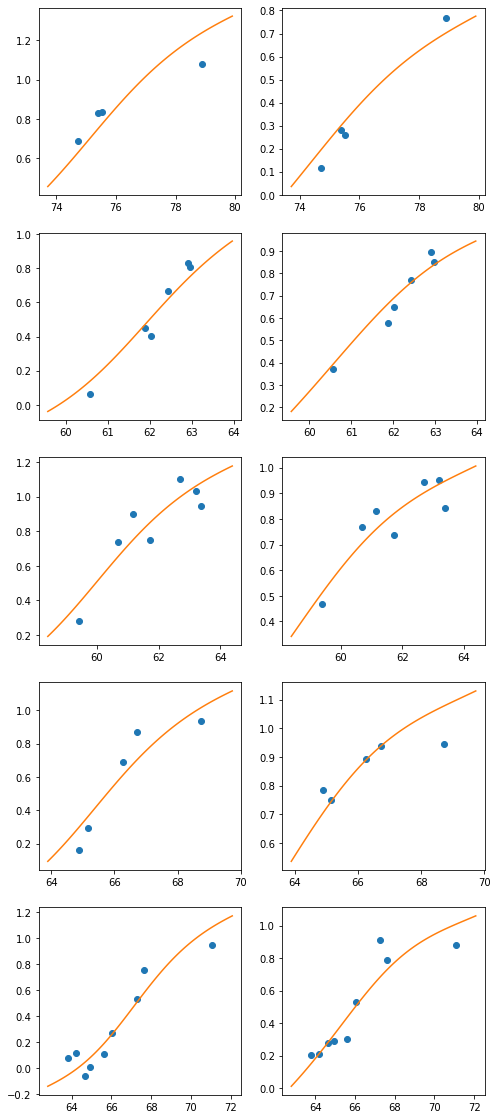

In [7]:
fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

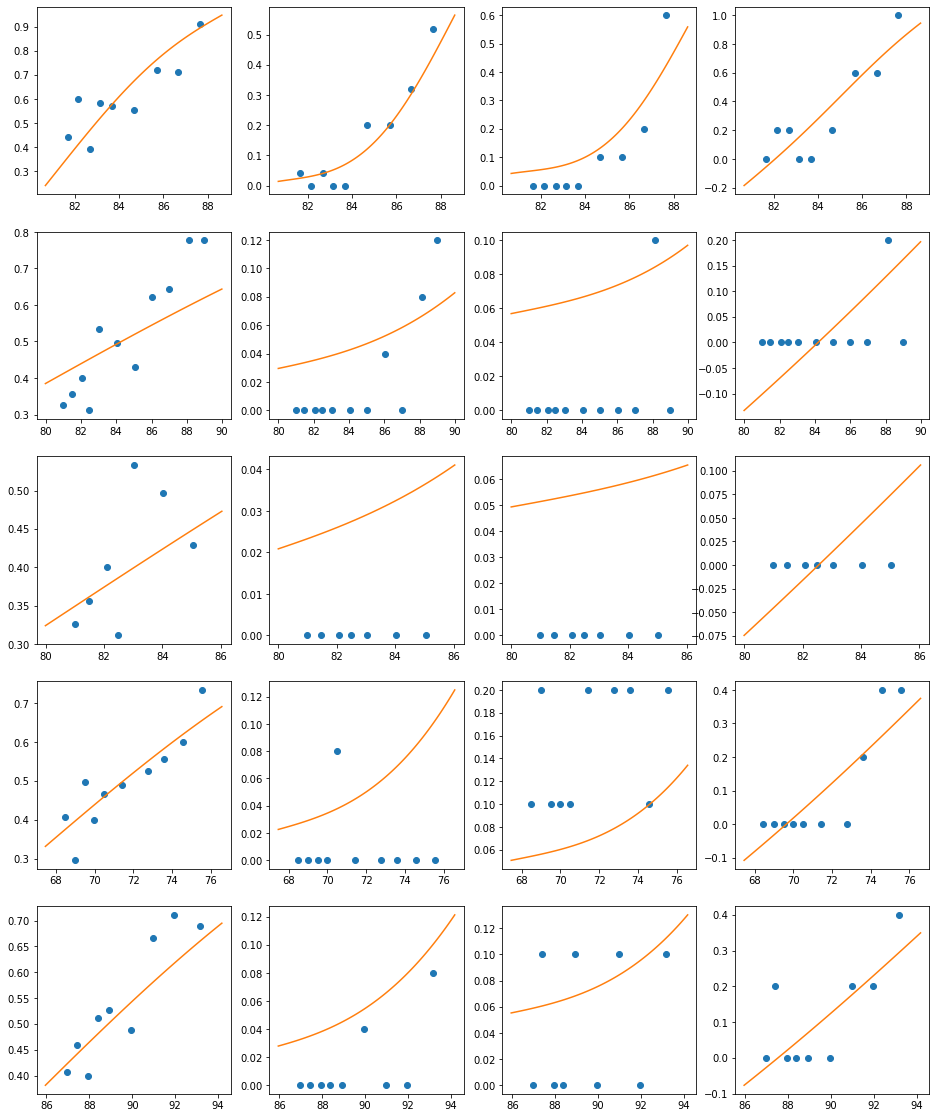

In [59]:
fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

In [ ]:
os.chdir("/Users/samuel.gruffaz/Documents/PEcollab")

In [63]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dimension=4

logi=lambda x: 1./(1.+torch.exp(-x))

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1., 
                 "nb_control_points" : 10,"nb_compose":2,'B_init':logi}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss="MSE_diag_noise")
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")



results=leaspy_test.fit_B(data,algo_settings,perso_settings,meta_settings)




The standard deviation of the noise at the end of the calibration is:
Y0: 0.1066
Y1: 0.0533
Y2: 0.0812
Y3: 0.1518

Calibration took: 13s

The standard deviation of the noise at the end of the personalization is:
Y0: 0.1017
Y1: 0.0485
Y2: 0.0794
Y3: 0.1390

Personalization scipy_minimize took: 29s
erreur projection
0.012522421
1
temps opti quadra
0.005231000000094355

The standard deviation of the noise at the end of the calibration is:
Y0: 0.1123
Y1: 0.0547
Y2: 0.0805
Y3: 0.1502

Calibration took: 3min 57s

The standard deviation of the noise at the end of the personalization is:
Y0: 0.0978
Y1: 0.0483
Y2: 0.0777
Y3: 0.1366

Personalization scipy_minimize took: 47s
erreur projection
0.007886497
temps opti quadra
0.011304999999993015


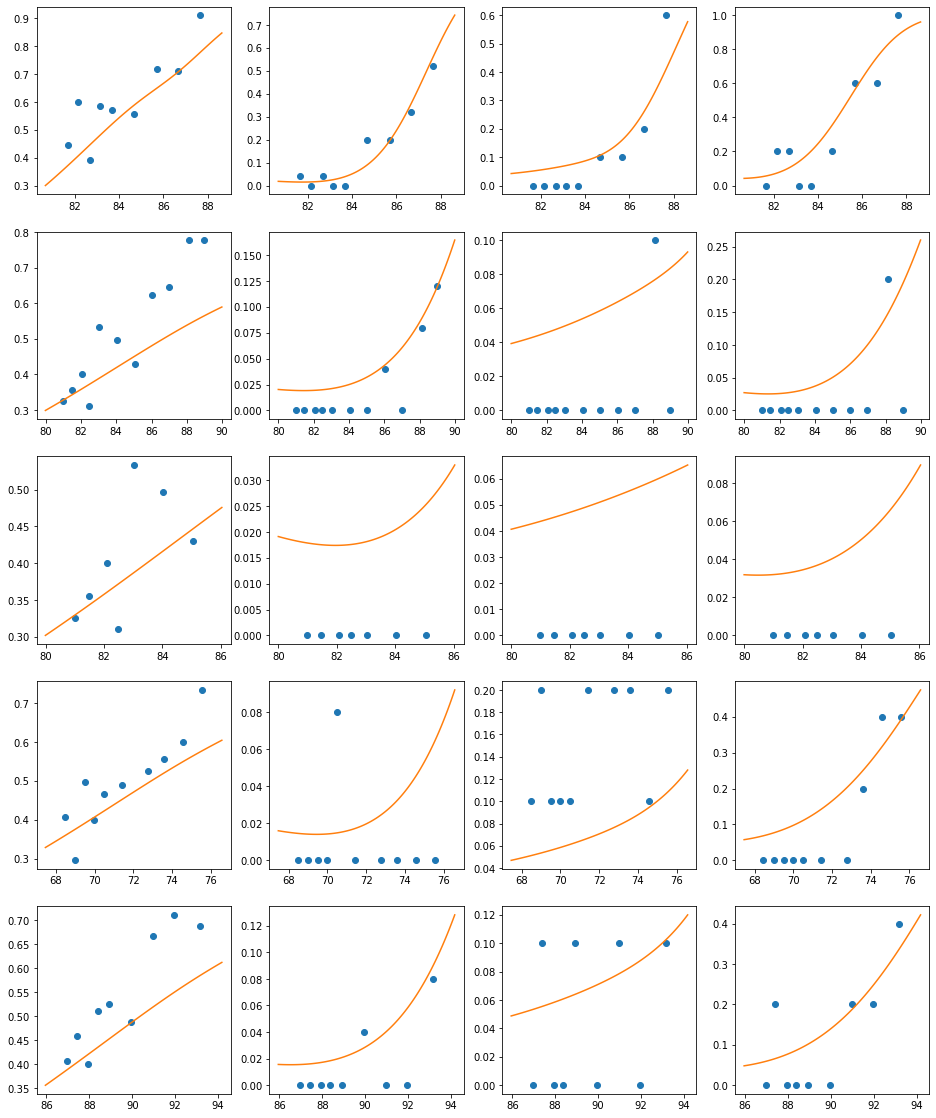

In [75]:
fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

In [77]:
# —— Get the average individual parameters
mean_xi = leaspy_test.model.parameters['xi_mean'].numpy()
mean_tau = leaspy_test.model.parameters['tau_mean'].numpy()
mean_source = leaspy_test.model.parameters['sources_mean'].numpy().tolist()
number_of_sources = leaspy_test.model.source_dimension
mean_sources = [mean_source]*number_of_sources

# —— Store the average individual parameters in a dedicated object
average_parameters = {
    'xi': mean_xi,
    'tau': mean_tau,
    'sources': mean_sources
}

ip_average = IndividualParameters()
ip_average.add_individual_parameters('average', average_parameters)
timepoints = np.linspace(50, 100, 100)
values = leaspy_test.estimate({'average': timepoints}, ip_average)

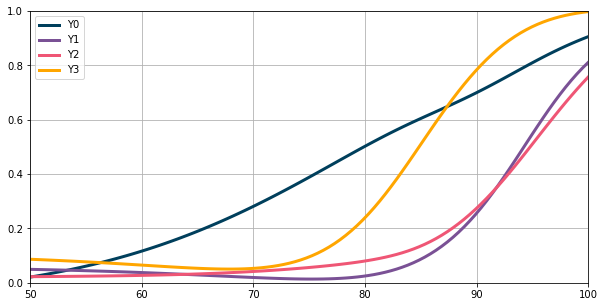

In [79]:
def plot_trajectory(timepoints, reconstruction, observations=None):

    if observations is not None:
        ages = observations.index.values
    
    plt.figure(figsize=(10, 5))
    plt.ylim(0, 1)
    colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600']
    
    for c, name, val in zip(colors, leaspy_test.model.features, reconstruction.T):
        plt.plot(timepoints, val, label=name, c=c, linewidth=3)
        if observations is not None:
            plt.plot(ages, observations[name], c=c, marker='o', markersize=12, 
                     linewidth=1, linestyle=':')
    
    plt.xlim(min(timepoints), max(timepoints))
    plt.grid()
    plt.legend()
    plt.show()
    
plot_trajectory(timepoints, values['average'])

In [80]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 2}) # Optional
dimension=4

logi=lambda x: 1./(1.+torch.exp(-x))

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1., 
                 "nb_control_points" : 10,"nb_compose":4,'B_init':logi}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss="MSE_diag_noise")
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")



results=leaspy_test.fit_B(data,algo_settings,perso_settings,meta_settings)


The standard deviation of the noise at the end of the calibration is:
Y0: 0.0756
Y1: 0.0480
Y2: 0.0827
Y3: 0.1425

Calibration took: 15s

The standard deviation of the noise at the end of the personalization is:
Y0: 0.0662
Y1: 0.0438
Y2: 0.0809
Y3: 0.1306

Personalization scipy_minimize took: 43s
erreur projection
0.006587433
temps opti quadra
0.011199999999917054

The standard deviation of the noise at the end of the calibration is:
Y0: 0.0740
Y1: 0.0479
Y2: 0.0804
Y3: 0.1427

Calibration took: 4min 43s

The standard deviation of the noise at the end of the personalization is:
Y0: 0.0651
Y1: 0.0436
Y2: 0.0785
Y3: 0.1308

Personalization scipy_minimize took: 1min 1s
erreur projection
0.011892758
temps opti quadra
0.011567999999897438

The standard deviation of the noise at the end of the calibration is:
Y0: 0.0760
Y1: 0.0527
Y2: 0.0788
Y3: 0.1448

Calibration took: 9min 2s

The standard deviation of the noise at the end of the personalization is:
Y0: 0.0656
Y1: 0.0439
Y2: 0.0769
Y3: 0

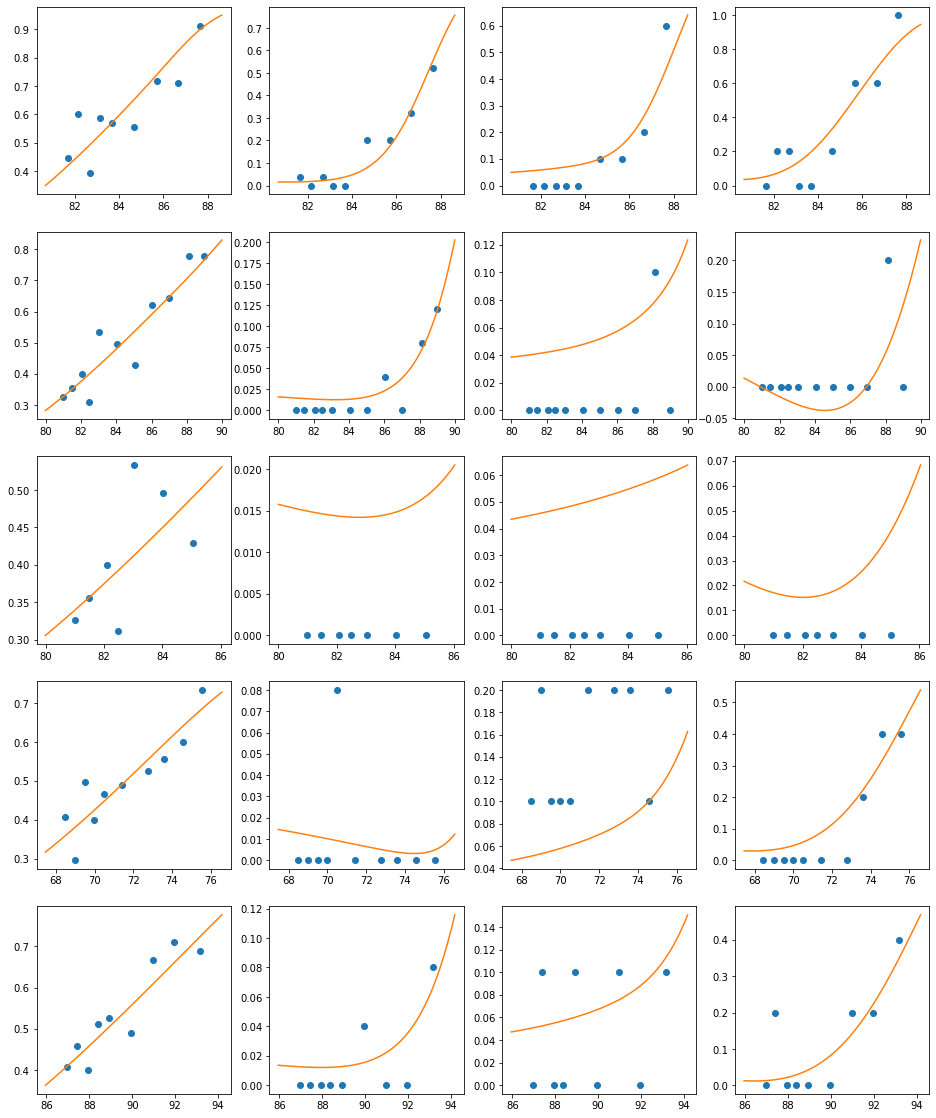

In [81]:
fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

In [82]:
# —— Get the average individual parameters
mean_xi = leaspy_test.model.parameters['xi_mean'].numpy()
mean_tau = leaspy_test.model.parameters['tau_mean'].numpy()
mean_source = leaspy_test.model.parameters['sources_mean'].numpy().tolist()
number_of_sources = leaspy_test.model.source_dimension
mean_sources = [mean_source]*number_of_sources

# —— Store the average individual parameters in a dedicated object
average_parameters = {
    'xi': mean_xi,
    'tau': mean_tau,
    'sources': mean_sources
}

ip_average = IndividualParameters()
ip_average.add_individual_parameters('average', average_parameters)
timepoints = np.linspace(50, 100, 100)
values = leaspy_test.estimate({'average': timepoints}, ip_average)

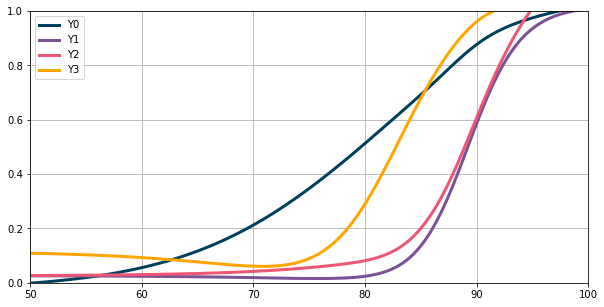

In [83]:
def plot_trajectory(timepoints, reconstruction, observations=None):

    if observations is not None:
        ages = observations.index.values
    
    plt.figure(figsize=(10, 5))
    plt.ylim(0, 1)
    colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600']
    
    for c, name, val in zip(colors, leaspy_test.model.features, reconstruction.T):
        plt.plot(timepoints, val, label=name, c=c, linewidth=3)
        if observations is not None:
            plt.plot(ages, observations[name], c=c, marker='o', markersize=12, 
                     linewidth=1, linestyle=':')
    
    plt.xlim(min(timepoints), max(timepoints))
    plt.grid()
    plt.legend()
    plt.show()
    
plot_trajectory(timepoints, values['average'])

In [6]:
os.chdir("/Users/samuel.gruffaz/Documents/data/")
df=pd.read_csv("ADNI_img_clean.csv")
df = df.set_index(['ID', 'TIME'])
indices = [idx for idx in df.index.unique('ID') if df.loc[idx].shape[0] >= 2]
df = df[df.index.get_level_values(0).isin(indices)]
dg=df[df.columns[3:6]]
data = Data.from_dataframe(dg)
dataset=Dataset(data)

In [7]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 2}) # Optional
dimension=3

logi=lambda x:-x

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1., 
                 "nb_control_points" : 10,"nb_compose":2,'B_init':logi}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss="MSE_diag_noise")
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")



results=leaspy_test.fit_B(data,algo_settings,perso_settings,meta_settings)

/Users/samuel.gruffaz/Documents/PEcollab/leaspy/models/utils/initialization/model_initialization.py:425: UserWarning: Mean slope of individual linear regressions made at initialization is negative for ['Precentral_L', 'Precentral_R', 'Frontal_Sup_2_L']: not properly handled in model...
  warnings.warn(f"Mean slope of individual linear regressions made at initialization is negative for {[f for f, vel in zip(model.features, velocities) if vel <= 0]}: not properly handled in model...")

The standard deviation of the noise at the end of the calibration is:
Precentral_L: 0.0226
Precentral_R: 0.0163
Frontal_Sup_2_L: 0.0133

Calibration took: 25s

The standard deviation of the noise at the end of the personalization is:
Precentral_L: 0.0202
Precentral_R: 0.0146
Frontal_Sup_2_L: 0.0111

Personalization scipy_minimize took: 3min 5s
erreur projection
0.015432622
temps opti quadra
0.025550999999978785

The standard deviation of the noise at the end of the calibration is:
Precentral_L: 0.0223
Prec

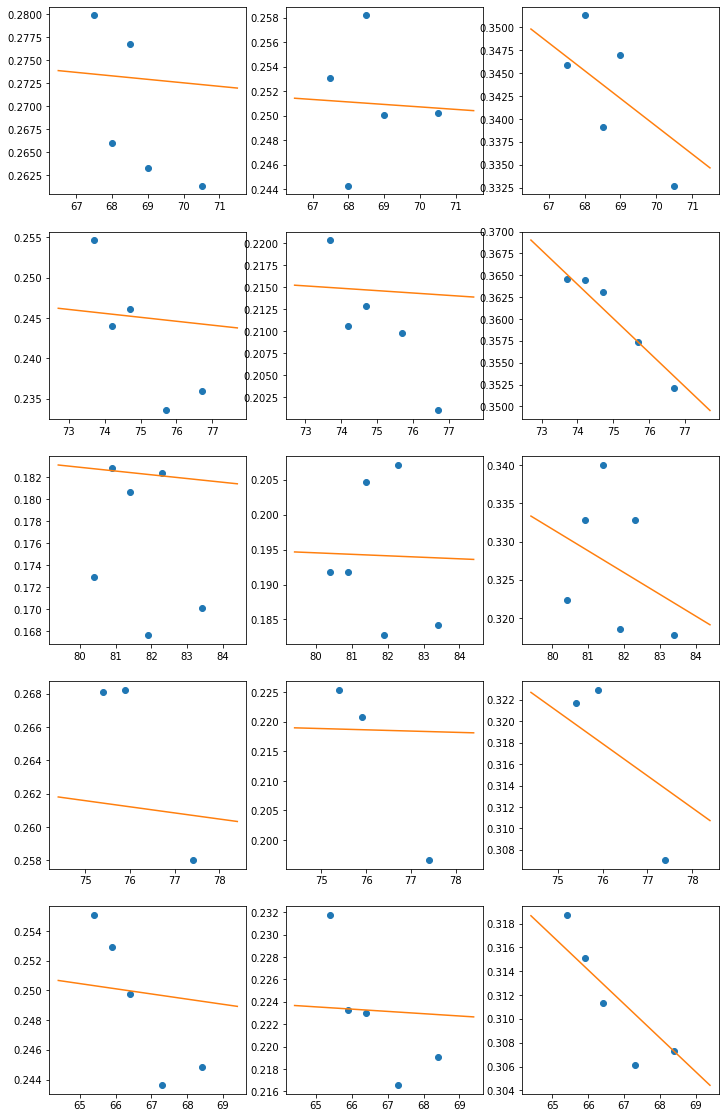

In [9]:
nb_ind_plot=5
dimension=3

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

In [10]:
# —— Get the average individual parameters
mean_xi = leaspy_test.model.parameters['xi_mean'].numpy()
mean_tau = leaspy_test.model.parameters['tau_mean'].numpy()
mean_source = leaspy_test.model.parameters['sources_mean'].numpy().tolist()
number_of_sources = leaspy_test.model.source_dimension
mean_sources = [mean_source]*number_of_sources

# —— Store the average individual parameters in a dedicated object
average_parameters = {
    'xi': mean_xi,
    'tau': mean_tau,
    'sources': mean_sources
}

ip_average = IndividualParameters()
ip_average.add_individual_parameters('average', average_parameters)
timepoints = np.linspace(50, 100, 100)
values = leaspy_test.estimate({'average': timepoints}, ip_average)

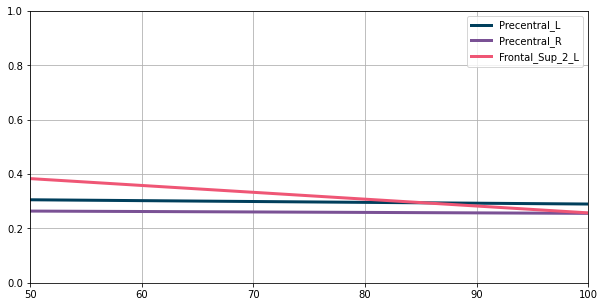

In [11]:
def plot_trajectory(timepoints, reconstruction, observations=None):

    if observations is not None:
        ages = observations.index.values
    
    plt.figure(figsize=(10, 5))
    plt.ylim(0, 1)
    colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600']
    
    for c, name, val in zip(colors, leaspy_test.model.features, reconstruction.T):
        plt.plot(timepoints, val, label=name, c=c, linewidth=3)
        if observations is not None:
            plt.plot(ages, observations[name], c=c, marker='o', markersize=12, 
                     linewidth=1, linestyle=':')
    
    plt.xlim(min(timepoints), max(timepoints))
    plt.grid()
    plt.legend()
    plt.show()
    
plot_trajectory(timepoints, values['average'])

In [12]:
os.chdir("/Users/samuel.gruffaz/Documents/data/")
df=pd.read_csv("ADNI_img_clean.csv")
df = df.set_index(['ID', 'TIME'])
indices = [idx for idx in df.index.unique('ID') if df.loc[idx].shape[0] >= 2]
df = df[df.index.get_level_values(0).isin(indices)]
dg=df[df.columns[3:6]]*3
data = Data.from_dataframe(dg)
dataset=Dataset(data)

In [13]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 2}) # Optional
dimension=3

logi=lambda x:-x

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1., 
                 "nb_control_points" : 10,"nb_compose":1,'B_init':logi}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss="MSE_diag_noise")
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")



results=leaspy_test.fit_B(data,algo_settings,perso_settings,meta_settings)

/Users/samuel.gruffaz/Documents/PEcollab/leaspy/models/utils/initialization/model_initialization.py:425: UserWarning: Mean slope of individual linear regressions made at initialization is negative for ['Precentral_L', 'Precentral_R', 'Frontal_Sup_2_L']: not properly handled in model...
  warnings.warn(f"Mean slope of individual linear regressions made at initialization is negative for {[f for f, vel in zip(model.features, velocities) if vel <= 0]}: not properly handled in model...")

The standard deviation of the noise at the end of the calibration is:
Precentral_L: 0.0675
Precentral_R: 0.0498
Frontal_Sup_2_L: 0.0405

Calibration took: 21s

The standard deviation of the noise at the end of the personalization is:
Precentral_L: 0.0606
Precentral_R: 0.0446
Frontal_Sup_2_L: 0.0334

Personalization scipy_minimize took: 2min 33s
erreur projection
0.0077967364
temps opti quadra
0.015900000000328873


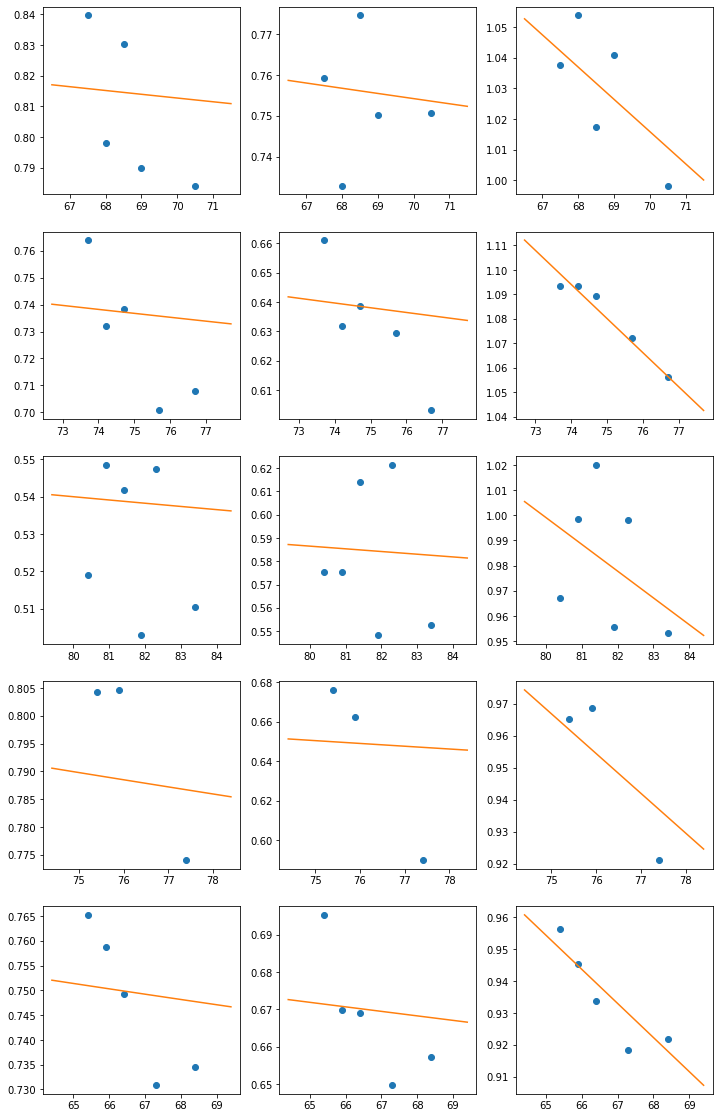

In [14]:
nb_ind_plot=5
dimension=3

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

In [16]:
# —— Get the average individual parameters
mean_xi = leaspy_test.model.parameters['xi_mean'].numpy()
mean_tau = leaspy_test.model.parameters['tau_mean'].numpy()
mean_source = leaspy_test.model.parameters['sources_mean'].numpy().tolist()
number_of_sources = leaspy_test.model.source_dimension
mean_sources = [mean_source]*number_of_sources

# —— Store the average individual parameters in a dedicated object
average_parameters = {
    'xi': mean_xi,
    'tau': mean_tau,
    'sources': mean_sources
}

ip_average = IndividualParameters()
ip_average.add_individual_parameters('average', average_parameters)
timepoints = np.linspace(50, 100, 100)
values = leaspy_test.estimate({'average': timepoints}, ip_average)

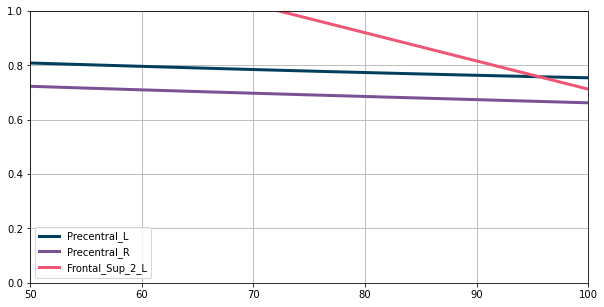

In [17]:
def plot_trajectory(timepoints, reconstruction, observations=None):

    if observations is not None:
        ages = observations.index.values
    
    plt.figure(figsize=(10, 5))
    plt.ylim(0, 1)
    colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600']
    
    for c, name, val in zip(colors, leaspy_test.model.features, reconstruction.T):
        plt.plot(timepoints, val, label=name, c=c, linewidth=3)
        if observations is not None:
            plt.plot(ages, observations[name], c=c, marker='o', markersize=12, 
                     linewidth=1, linestyle=':')
    
    plt.xlim(min(timepoints), max(timepoints))
    plt.grid()
    plt.legend()
    plt.show()
    
plot_trajectory(timepoints, values['average'])

In [19]:
os.chdir("/Users/samuel.gruffaz/Documents/data/")
df=pd.read_csv("ADNI_img_clean.csv")
df = df.set_index(['ID', 'TIME'])
indices = [idx for idx in df.index.unique('ID') if df.loc[idx].shape[0] >= 2]
df = df[df.index.get_level_values(0).isin(indices)]
dg=df[df.columns[43:49]]*3
data = Data.from_dataframe(dg)
dataset=Dataset(data)



In [20]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 2}) # Optional
dimension=3

logi=lambda x:-x

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 3., 
                 "nb_control_points" : 10,"nb_compose":1,'B_init':logi}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss="MSE_diag_noise")
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")



results=leaspy_test.fit_B(data,algo_settings,perso_settings,meta_settings)

/Users/samuel.gruffaz/Documents/PEcollab/leaspy/models/utils/initialization/model_initialization.py:425: UserWarning: Mean slope of individual linear regressions made at initialization is negative for ['Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R']: not properly handled in model...
  warnings.warn(f"Mean slope of individual linear regressions made at initialization is negative for {[f for f, vel in zip(model.features, velocities) if vel <= 0]}: not properly handled in model...")

The standard deviation of the noise at the end of the calibration is:
Hippocampus_L: 0.0497
Hippocampus_R: 0.0600
ParaHippocampal_L: 0.0661
ParaHippocampal_R: 0.0705
Amygdala_L: 0.1270
Amygdala_R: 0.0947

Calibration took: 43s

The standard deviation of the noise at the end of the personalization is:
Hippocampus_L: 0.0450
Hippocampus_R: 0.0579
ParaHippocampal_L: 0.0633
ParaHippocampal_R: 0.0656
Amygdala_L: 0.1221
Amygdala_R: 0.0792

Personalization scipy

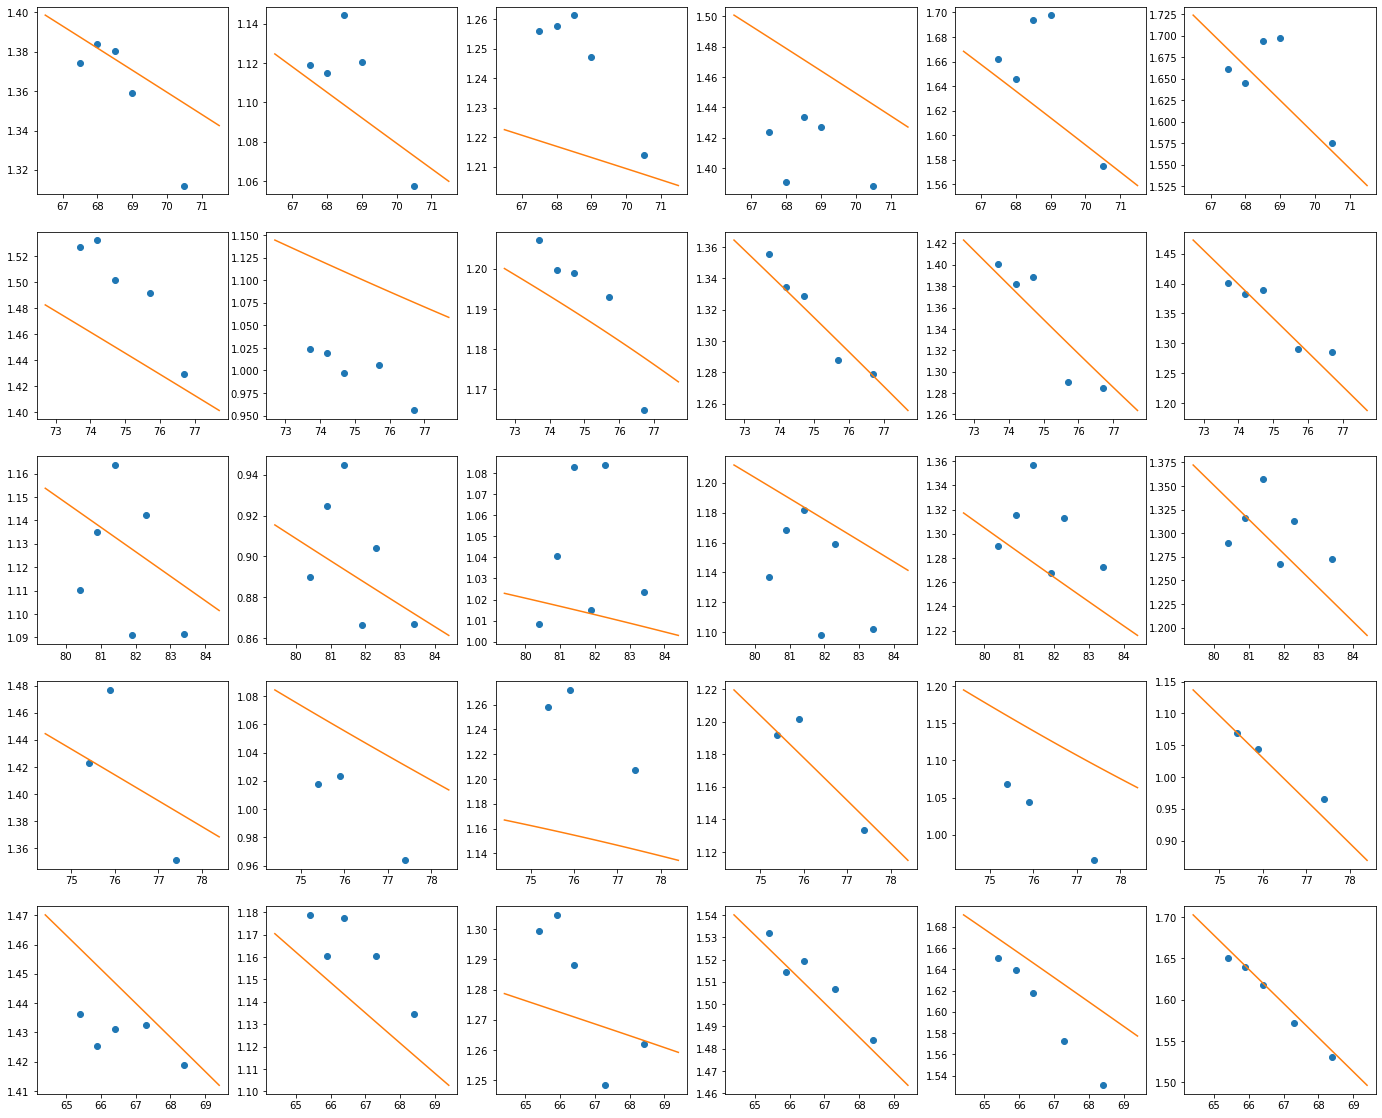

In [21]:
nb_ind_plot=5
dimension=6

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

In [22]:
# —— Get the average individual parameters
mean_xi = leaspy_test.model.parameters['xi_mean'].numpy()
mean_tau = leaspy_test.model.parameters['tau_mean'].numpy()
mean_source = leaspy_test.model.parameters['sources_mean'].numpy().tolist()
number_of_sources = leaspy_test.model.source_dimension
mean_sources = [mean_source]*number_of_sources

# —— Store the average individual parameters in a dedicated object
average_parameters = {
    'xi': mean_xi,
    'tau': mean_tau,
    'sources': mean_sources
}

ip_average = IndividualParameters()
ip_average.add_individual_parameters('average', average_parameters)
timepoints = np.linspace(50, 100, 100)
values = leaspy_test.estimate({'average': timepoints}, ip_average)

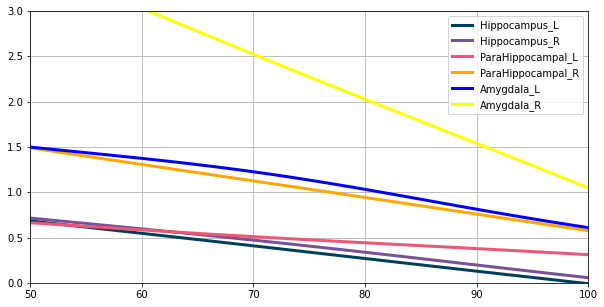

In [26]:
def plot_trajectory(timepoints, reconstruction, observations=None):

    if observations is not None:
        ages = observations.index.values
    
    plt.figure(figsize=(10, 5))
    plt.ylim(0, 3)
    colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600',"blue","yellow"]
    
    for c, name, val in zip(colors, leaspy_test.model.features, reconstruction.T):
        plt.plot(timepoints, val, label=name, c=c, linewidth=3)
        if observations is not None:
            plt.plot(ages, observations[name], c=c, marker='o', markersize=12, 
                     linewidth=1, linestyle=':')
    
    plt.xlim(min(timepoints), max(timepoints))
    plt.grid()
    plt.legend()
    plt.show()

plot_trajectory(timepoints, values['average'])

In [28]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 2}) # Optional
dimension=3

logi=lambda x:-x

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 3., 
                 "nb_control_points" : 10,"nb_compose":1,'B_init':logi}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss="MSE_diag_noise")
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")



results=leaspy_test.fit_B(data,algo_settings,perso_settings,meta_settings)


The standard deviation of the noise at the end of the calibration is:
Hippocampus_L: 0.0482
Hippocampus_R: 0.0601
ParaHippocampal_L: 0.0733
ParaHippocampal_R: 0.0660
Amygdala_L: 0.1180
Amygdala_R: 0.1262

Calibration took: 41s

The standard deviation of the noise at the end of the personalization is:
Hippocampus_L: 0.0442
Hippocampus_R: 0.0582
ParaHippocampal_L: 0.0722
ParaHippocampal_R: 0.0598
Amygdala_L: 0.1114
Amygdala_R: 0.0920

Personalization scipy_minimize took: 4min 10s
erreur projection
0.011905554
1
2
4
temps opti quadra
0.005454000000099768


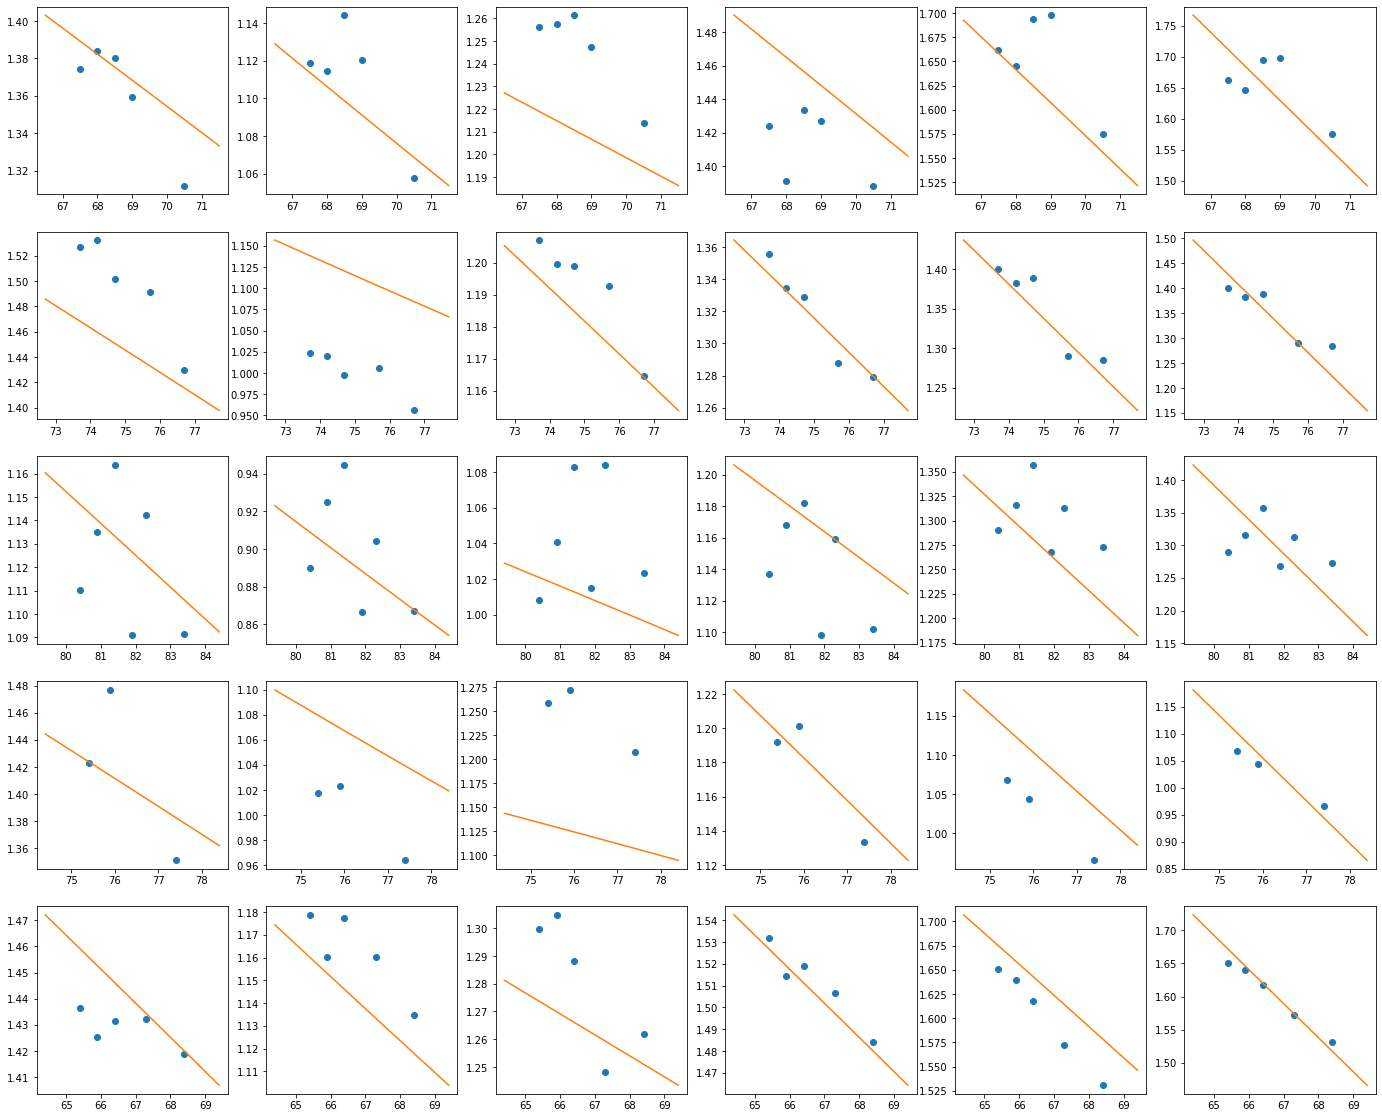

In [29]:
nb_ind_plot=5
dimension=6

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

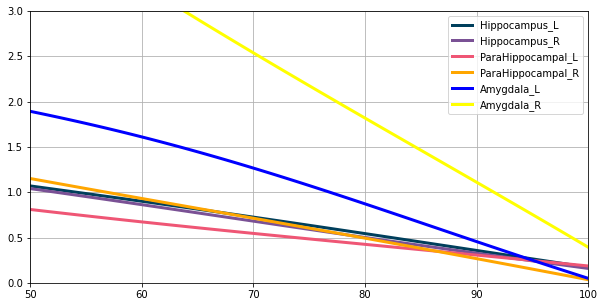

In [30]:
# —— Get the average individual parameters
mean_xi = leaspy_test.model.parameters['xi_mean'].numpy()
mean_tau = leaspy_test.model.parameters['tau_mean'].numpy()
mean_source = leaspy_test.model.parameters['sources_mean'].numpy().tolist()
number_of_sources = leaspy_test.model.source_dimension
mean_sources = [mean_source]*number_of_sources

# —— Store the average individual parameters in a dedicated object
average_parameters = {
    'xi': mean_xi,
    'tau': mean_tau,
    'sources': mean_sources
}

ip_average = IndividualParameters()
ip_average.add_individual_parameters('average', average_parameters)
timepoints = np.linspace(50, 100, 100)
values = leaspy_test.estimate({'average': timepoints}, ip_average)
def plot_trajectory(timepoints, reconstruction, observations=None):

    if observations is not None:
        ages = observations.index.values
    
    plt.figure(figsize=(10, 5))
    plt.ylim(0, 3)
    colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600',"blue","yellow"]
    
    for c, name, val in zip(colors, leaspy_test.model.features, reconstruction.T):
        plt.plot(timepoints, val, label=name, c=c, linewidth=3)
        if observations is not None:
            plt.plot(ages, observations[name], c=c, marker='o', markersize=12, 
                     linewidth=1, linestyle=':')
    
    plt.xlim(min(timepoints), max(timepoints))
    plt.grid()
    plt.legend()
    plt.show()

plot_trajectory(timepoints, values['average'])

In [31]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 4}) # Optional
dimension=3

logi=lambda x:-x

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 2., 
                 "nb_control_points" : 10,"nb_compose":2,'B_init':logi}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss="MSE_diag_noise")
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")



results=leaspy_test.fit_B(data,algo_settings,perso_settings,meta_settings)

/Users/samuel.gruffaz/Documents/PEcollab/leaspy/models/utils/initialization/model_initialization.py:425: UserWarning: Mean slope of individual linear regressions made at initialization is negative for ['Hippocampus_L', 'Hippocampus_R', 'ParaHippocampal_L', 'ParaHippocampal_R', 'Amygdala_L', 'Amygdala_R']: not properly handled in model...
  warnings.warn(f"Mean slope of individual linear regressions made at initialization is negative for {[f for f, vel in zip(model.features, velocities) if vel <= 0]}: not properly handled in model...")

The standard deviation of the noise at the end of the calibration is:
Hippocampus_L: 0.0585
Hippocampus_R: 0.0426
ParaHippocampal_L: 0.0429
ParaHippocampal_R: 0.0595
Amygdala_L: 0.0857
Amygdala_R: 0.0822

Calibration took: 57s

The standard deviation of the noise at the end of the personalization is:
Hippocampus_L: 0.0533
Hippocampus_R: 0.0360
ParaHippocampal_L: 0.0335
ParaHippocampal_R: 0.0490
Amygdala_L: 0.0765
Amygdala_R: 0.0713

Personalization scipy

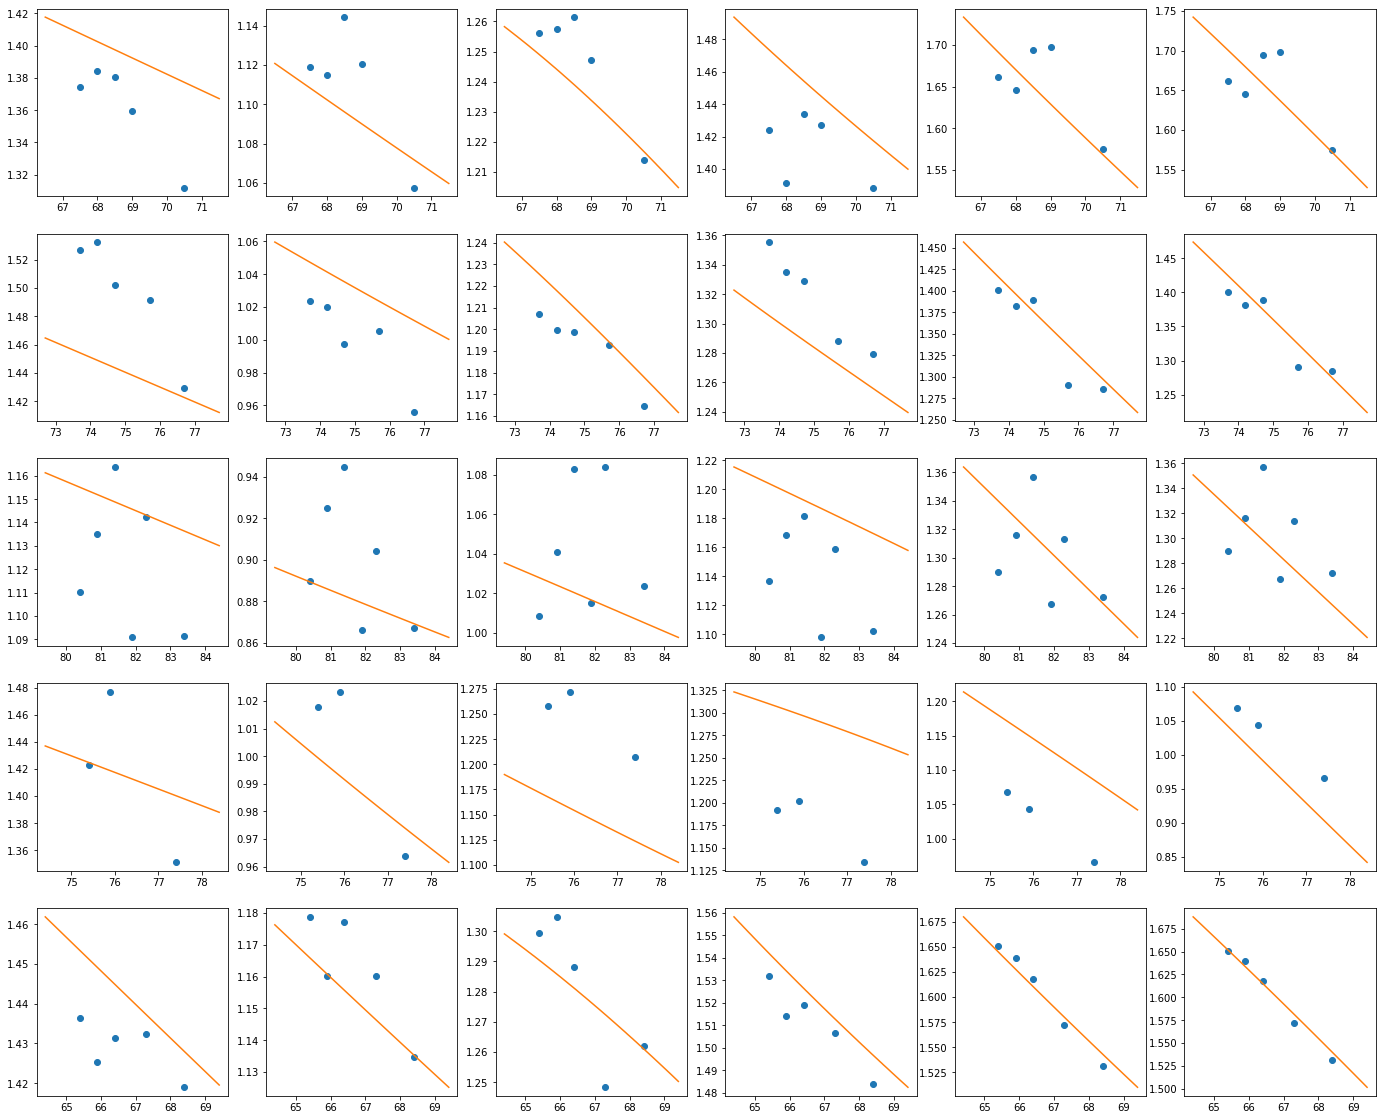

In [32]:
nb_ind_plot=5
dimension=6

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

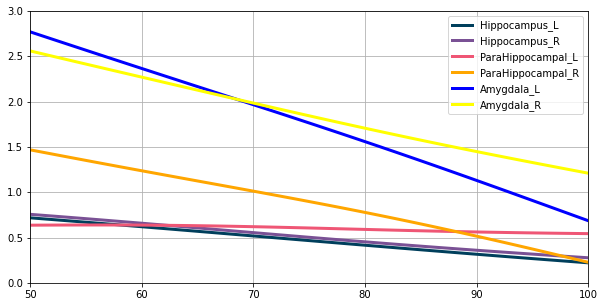

In [33]:
# —— Get the average individual parameters
mean_xi = leaspy_test.model.parameters['xi_mean'].numpy()
mean_tau = leaspy_test.model.parameters['tau_mean'].numpy()
mean_source = leaspy_test.model.parameters['sources_mean'].numpy().tolist()
number_of_sources = leaspy_test.model.source_dimension
mean_sources = [mean_source]*number_of_sources

# —— Store the average individual parameters in a dedicated object
average_parameters = {
    'xi': mean_xi,
    'tau': mean_tau,
    'sources': mean_sources
}

ip_average = IndividualParameters()
ip_average.add_individual_parameters('average', average_parameters)
timepoints = np.linspace(50, 100, 100)
values = leaspy_test.estimate({'average': timepoints}, ip_average)
def plot_trajectory(timepoints, reconstruction, observations=None):

    if observations is not None:
        ages = observations.index.values
    
    plt.figure(figsize=(10, 5))
    plt.ylim(0, 3)
    colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600',"blue","yellow"]
    
    for c, name, val in zip(colors, leaspy_test.model.features, reconstruction.T):
        plt.plot(timepoints, val, label=name, c=c, linewidth=3)
        if observations is not None:
            plt.plot(ages, observations[name], c=c, marker='o', markersize=12, 
                     linewidth=1, linestyle=':')
    
    plt.xlim(min(timepoints), max(timepoints))
    plt.grid()
    plt.legend()
    plt.show()

plot_trajectory(timepoints, values['average'])